In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3467748, 828)
(3467748, 8)
validation
(489242, 828)
(489242, 8)
test
(428799, 828)
(428799, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/347 [..............................] - ETA: 8:20 - loss: 2.4469 - STD: 0.0919 - MAE: 0.2208

  4/347 [..............................] - ETA: 6s - loss: 2.2068 - STD: 0.0542 - MAE: 0.2186  

  7/347 [..............................] - ETA: 6s - loss: 2.1538 - STD: 0.0602 - MAE: 0.2168

 10/347 [..............................] - ETA: 6s - loss: 2.1364 - STD: 0.0585 - MAE: 0.2166

 13/347 [>.............................] - ETA: 6s - loss: 2.1228 - STD: 0.0539 - MAE: 0.2167

 16/347 [>.............................] - ETA: 6s - loss: 2.1094 - STD: 0.0498 - MAE: 0.2167

 19/347 [>.............................] - ETA: 6s - loss: 2.1007 - STD: 0.0477 - MAE: 0.2167

 22/347 [>.............................] - ETA: 5s - loss: 2.0952 - STD: 0.0461 - MAE: 0.2167

 25/347 [=>............................] - ETA: 5s - loss: 2.0907 - STD: 0.0443 - MAE: 0.2167

 28/347 [=>............................] - ETA: 5s - loss: 2.0865 - STD: 0.0425 - MAE: 0.2167

 31/347 [=>............................] - ETA: 5s - loss: 2.0829 - STD: 0.0412 - MAE: 0.2167

 34/347 [=>............................] - ETA: 5s - loss: 2.0800 - STD: 0.0406 - MAE: 0.2167

 37/347 [==>...........................] - ETA: 5s - loss: 2.0773 - STD: 0.0402 - MAE: 0.2167

 40/347 [==>...........................] - ETA: 5s - loss: 2.0746 - STD: 0.0397 - MAE: 0.2167

 43/347 [==>...........................] - ETA: 5s - loss: 2.0719 - STD: 0.0392 - MAE: 0.2166

 46/347 [==>...........................] - ETA: 5s - loss: 2.0690 - STD: 0.0388 - MAE: 0.2166

 49/347 [===>..........................] - ETA: 5s - loss: 2.0658 - STD: 0.0384 - MAE: 0.2165

 52/347 [===>..........................] - ETA: 5s - loss: 2.0621 - STD: 0.0381 - MAE: 0.2164

 56/347 [===>..........................] - ETA: 5s - loss: 2.0560 - STD: 0.0382 - MAE: 0.2162

 59/347 [====>.........................] - ETA: 5s - loss: 2.0506 - STD: 0.0385 - MAE: 0.2160

 62/347 [====>.........................] - ETA: 5s - loss: 2.0443 - STD: 0.0393 - MAE: 0.2157

 65/347 [====>.........................] - ETA: 5s - loss: 2.0376 - STD: 0.0402 - MAE: 0.2154

 68/347 [====>.........................] - ETA: 4s - loss: 2.0301 - STD: 0.0412 - MAE: 0.2151

 71/347 [=====>........................] - ETA: 4s - loss: 2.0218 - STD: 0.0424 - MAE: 0.2147

 74/347 [=====>........................] - ETA: 4s - loss: 2.0131 - STD: 0.0437 - MAE: 0.2143

 77/347 [=====>........................] - ETA: 4s - loss: 2.0041 - STD: 0.0451 - MAE: 0.2138

 80/347 [=====>........................] - ETA: 4s - loss: 1.9944 - STD: 0.0465 - MAE: 0.2134

 83/347 [======>.......................] - ETA: 4s - loss: 1.9837 - STD: 0.0480 - MAE: 0.2128

 86/347 [======>.......................] - ETA: 4s - loss: 1.9724 - STD: 0.0496 - MAE: 0.2122

 89/347 [======>.......................] - ETA: 4s - loss: 1.9603 - STD: 0.0513 - MAE: 0.2116

 92/347 [======>.......................] - ETA: 4s - loss: 1.9480 - STD: 0.0531 - MAE: 0.2109

 95/347 [=======>......................] - ETA: 4s - loss: 1.9354 - STD: 0.0550 - MAE: 0.2102

 98/347 [=======>......................] - ETA: 4s - loss: 1.9228 - STD: 0.0570 - MAE: 0.2094

101/347 [=======>......................] - ETA: 4s - loss: 1.9106 - STD: 0.0590 - MAE: 0.2087

104/347 [=======>......................] - ETA: 4s - loss: 1.8983 - STD: 0.0610 - MAE: 0.2079

108/347 [========>.....................] - ETA: 4s - loss: 1.8827 - STD: 0.0636 - MAE: 0.2069

111/347 [========>.....................] - ETA: 4s - loss: 1.8714 - STD: 0.0655 - MAE: 0.2062

114/347 [========>.....................] - ETA: 4s - loss: 1.8604 - STD: 0.0674 - MAE: 0.2054

117/347 [=========>....................] - ETA: 4s - loss: 1.8499 - STD: 0.0691 - MAE: 0.2047

120/347 [=========>....................] - ETA: 4s - loss: 1.8397 - STD: 0.0708 - MAE: 0.2041

123/347 [=========>....................] - ETA: 4s - loss: 1.8298 - STD: 0.0725 - MAE: 0.2034

126/347 [=========>....................] - ETA: 3s - loss: 1.8203 - STD: 0.0741 - MAE: 0.2028

129/347 [==========>...................] - ETA: 3s - loss: 1.8110 - STD: 0.0757 - MAE: 0.2021

132/347 [==========>...................] - ETA: 3s - loss: 1.8019 - STD: 0.0772 - MAE: 0.2015

135/347 [==========>...................] - ETA: 3s - loss: 1.7929 - STD: 0.0787 - MAE: 0.2009

138/347 [==========>...................] - ETA: 3s - loss: 1.7841 - STD: 0.0801 - MAE: 0.2003

141/347 [===========>..................] - ETA: 3s - loss: 1.7755 - STD: 0.0815 - MAE: 0.1997

144/347 [===========>..................] - ETA: 3s - loss: 1.7672 - STD: 0.0829 - MAE: 0.1991

147/347 [===========>..................] - ETA: 3s - loss: 1.7592 - STD: 0.0843 - MAE: 0.1985

150/347 [===========>..................] - ETA: 3s - loss: 1.7512 - STD: 0.0856 - MAE: 0.1979

153/347 [============>.................] - ETA: 3s - loss: 1.7435 - STD: 0.0869 - MAE: 0.1974

156/347 [============>.................] - ETA: 3s - loss: 1.7361 - STD: 0.0882 - MAE: 0.1968

159/347 [============>.................] - ETA: 3s - loss: 1.7291 - STD: 0.0894 - MAE: 0.1963

162/347 [=============>................] - ETA: 3s - loss: 1.7219 - STD: 0.0906 - MAE: 0.1957

165/347 [=============>................] - ETA: 4s - loss: 1.7155 - STD: 0.0919 - MAE: 0.1952

168/347 [=============>................] - ETA: 4s - loss: 1.7087 - STD: 0.0930 - MAE: 0.1947

171/347 [=============>................] - ETA: 3s - loss: 1.7020 - STD: 0.0942 - MAE: 0.1942

174/347 [==============>...............] - ETA: 3s - loss: 1.6956 - STD: 0.0953 - MAE: 0.1937

177/347 [==============>...............] - ETA: 3s - loss: 1.6892 - STD: 0.0965 - MAE: 0.1932

180/347 [==============>...............] - ETA: 3s - loss: 1.6829 - STD: 0.0975 - MAE: 0.1927

183/347 [==============>...............] - ETA: 3s - loss: 1.6769 - STD: 0.0986 - MAE: 0.1922

186/347 [===============>..............] - ETA: 3s - loss: 1.6711 - STD: 0.0996 - MAE: 0.1917

189/347 [===============>..............] - ETA: 3s - loss: 1.6654 - STD: 0.1006 - MAE: 0.1913

192/347 [===============>..............] - ETA: 3s - loss: 1.6596 - STD: 0.1016 - MAE: 0.1908

196/347 [===============>..............] - ETA: 3s - loss: 1.6522 - STD: 0.1029 - MAE: 0.1902

199/347 [================>.............] - ETA: 3s - loss: 1.6469 - STD: 0.1039 - MAE: 0.1898

202/347 [================>.............] - ETA: 3s - loss: 1.6416 - STD: 0.1048 - MAE: 0.1894

205/347 [================>.............] - ETA: 3s - loss: 1.6366 - STD: 0.1057 - MAE: 0.1890

208/347 [================>.............] - ETA: 2s - loss: 1.6317 - STD: 0.1066 - MAE: 0.1886

211/347 [=================>............] - ETA: 2s - loss: 1.6267 - STD: 0.1074 - MAE: 0.1882

214/347 [=================>............] - ETA: 2s - loss: 1.6217 - STD: 0.1083 - MAE: 0.1878

217/347 [=================>............] - ETA: 2s - loss: 1.6168 - STD: 0.1091 - MAE: 0.1874

220/347 [==================>...........] - ETA: 2s - loss: 1.6121 - STD: 0.1099 - MAE: 0.1870

223/347 [==================>...........] - ETA: 2s - loss: 1.6074 - STD: 0.1108 - MAE: 0.1866

226/347 [==================>...........] - ETA: 2s - loss: 1.6029 - STD: 0.1115 - MAE: 0.1862

229/347 [==================>...........] - ETA: 2s - loss: 1.5986 - STD: 0.1123 - MAE: 0.1859

232/347 [===================>..........] - ETA: 2s - loss: 1.5942 - STD: 0.1131 - MAE: 0.1855

235/347 [===================>..........] - ETA: 2s - loss: 1.5899 - STD: 0.1138 - MAE: 0.1852

239/347 [===================>..........] - ETA: 2s - loss: 1.5841 - STD: 0.1148 - MAE: 0.1847

242/347 [===================>..........] - ETA: 2s - loss: 1.5799 - STD: 0.1156 - MAE: 0.1843

245/347 [====================>.........] - ETA: 2s - loss: 1.5759 - STD: 0.1163 - MAE: 0.1840

248/347 [====================>.........] - ETA: 2s - loss: 1.5720 - STD: 0.1170 - MAE: 0.1837

251/347 [====================>.........] - ETA: 1s - loss: 1.5682 - STD: 0.1177 - MAE: 0.1833

254/347 [====================>.........] - ETA: 1s - loss: 1.5643 - STD: 0.1183 - MAE: 0.1830

257/347 [=====================>........] - ETA: 1s - loss: 1.5606 - STD: 0.1190 - MAE: 0.1827

260/347 [=====================>........] - ETA: 1s - loss: 1.5569 - STD: 0.1197 - MAE: 0.1824

263/347 [=====================>........] - ETA: 1s - loss: 1.5532 - STD: 0.1203 - MAE: 0.1820

266/347 [=====================>........] - ETA: 1s - loss: 1.5496 - STD: 0.1209 - MAE: 0.1817

269/347 [======================>.......] - ETA: 1s - loss: 1.5461 - STD: 0.1215 - MAE: 0.1814

272/347 [======================>.......] - ETA: 1s - loss: 1.5426 - STD: 0.1222 - MAE: 0.1811

275/347 [======================>.......] - ETA: 1s - loss: 1.5393 - STD: 0.1228 - MAE: 0.1809

278/347 [=======================>......] - ETA: 1s - loss: 1.5361 - STD: 0.1234 - MAE: 0.1806

281/347 [=======================>......] - ETA: 1s - loss: 1.5327 - STD: 0.1239 - MAE: 0.1803

284/347 [=======================>......] - ETA: 1s - loss: 1.5295 - STD: 0.1245 - MAE: 0.1800

287/347 [=======================>......] - ETA: 1s - loss: 1.5263 - STD: 0.1251 - MAE: 0.1797

290/347 [========================>.....] - ETA: 1s - loss: 1.5233 - STD: 0.1256 - MAE: 0.1795

293/347 [========================>.....] - ETA: 1s - loss: 1.5202 - STD: 0.1262 - MAE: 0.1792

296/347 [========================>.....] - ETA: 1s - loss: 1.5172 - STD: 0.1267 - MAE: 0.1789

299/347 [========================>.....] - ETA: 0s - loss: 1.5142 - STD: 0.1272 - MAE: 0.1787

302/347 [=========================>....] - ETA: 0s - loss: 1.5112 - STD: 0.1277 - MAE: 0.1784

305/347 [=========================>....] - ETA: 0s - loss: 1.5084 - STD: 0.1282 - MAE: 0.1782

308/347 [=========================>....] - ETA: 0s - loss: 1.5054 - STD: 0.1287 - MAE: 0.1779

311/347 [=========================>....] - ETA: 0s - loss: 1.5025 - STD: 0.1292 - MAE: 0.1777

314/347 [==========================>...] - ETA: 0s - loss: 1.4996 - STD: 0.1297 - MAE: 0.1774

317/347 [==========================>...] - ETA: 0s - loss: 1.4969 - STD: 0.1302 - MAE: 0.1772

321/347 [==========================>...] - ETA: 0s - loss: 1.4932 - STD: 0.1308 - MAE: 0.1769

324/347 [===========================>..] - ETA: 0s - loss: 1.4905 - STD: 0.1313 - MAE: 0.1766

328/347 [===========================>..] - ETA: 0s - loss: 1.4869 - STD: 0.1319 - MAE: 0.1763

331/347 [===========================>..] - ETA: 0s - loss: 1.4843 - STD: 0.1324 - MAE: 0.1761

334/347 [===========================>..] - ETA: 0s - loss: 1.4815 - STD: 0.1328 - MAE: 0.1759

337/347 [============================>.] - ETA: 0s - loss: 1.4790 - STD: 0.1333 - MAE: 0.1756

340/347 [============================>.] - ETA: 0s - loss: 1.4765 - STD: 0.1337 - MAE: 0.1754

343/347 [============================>.] - ETA: 0s - loss: 1.4740 - STD: 0.1342 - MAE: 0.1752

346/347 [============================>.] - ETA: 0s - loss: 1.4714 - STD: 0.1346 - MAE: 0.1750

347/347 [==============================] - 10s 24ms/step - loss: 1.4706 - STD: 0.1347 - MAE: 0.1749 - val_loss: 1.2318 - val_STD: 0.1845 - val_MAE: 0.1506


Epoch 2/10000


  1/347 [..............................] - ETA: 20s - loss: 1.1602 - STD: 0.1832 - MAE: 0.1490

  4/347 [..............................] - ETA: 7s - loss: 1.1796 - STD: 0.1835 - MAE: 0.1496 

  7/347 [..............................] - ETA: 6s - loss: 1.1811 - STD: 0.1839 - MAE: 0.1496

 10/347 [..............................] - ETA: 6s - loss: 1.1809 - STD: 0.1842 - MAE: 0.1494

 13/347 [>.............................] - ETA: 6s - loss: 1.1864 - STD: 0.1841 - MAE: 0.1497

 16/347 [>.............................] - ETA: 5s - loss: 1.1898 - STD: 0.1841 - MAE: 0.1499

 19/347 [>.............................] - ETA: 5s - loss: 1.1886 - STD: 0.1841 - MAE: 0.1498

 22/347 [>.............................] - ETA: 5s - loss: 1.1869 - STD: 0.1843 - MAE: 0.1497

 25/347 [=>............................] - ETA: 5s - loss: 1.1854 - STD: 0.1844 - MAE: 0.1495

 28/347 [=>............................] - ETA: 5s - loss: 1.1844 - STD: 0.1845 - MAE: 0.1495

 31/347 [=>............................] - ETA: 5s - loss: 1.1841 - STD: 0.1846 - MAE: 0.1494

 34/347 [=>............................] - ETA: 5s - loss: 1.1856 - STD: 0.1846 - MAE: 0.1494

 37/347 [==>...........................] - ETA: 5s - loss: 1.1852 - STD: 0.1847 - MAE: 0.1494

 40/347 [==>...........................] - ETA: 5s - loss: 1.1842 - STD: 0.1848 - MAE: 0.1493

 43/347 [==>...........................] - ETA: 5s - loss: 1.1833 - STD: 0.1848 - MAE: 0.1492

 46/347 [==>...........................] - ETA: 5s - loss: 1.1824 - STD: 0.1849 - MAE: 0.1492

 49/347 [===>..........................] - ETA: 5s - loss: 1.1810 - STD: 0.1849 - MAE: 0.1491

 52/347 [===>..........................] - ETA: 5s - loss: 1.1797 - STD: 0.1850 - MAE: 0.1490

 55/347 [===>..........................] - ETA: 5s - loss: 1.1785 - STD: 0.1850 - MAE: 0.1489

 58/347 [====>.........................] - ETA: 5s - loss: 1.1778 - STD: 0.1851 - MAE: 0.1489

 61/347 [====>.........................] - ETA: 5s - loss: 1.1770 - STD: 0.1853 - MAE: 0.1488

 64/347 [====>.........................] - ETA: 5s - loss: 1.1762 - STD: 0.1853 - MAE: 0.1487

 67/347 [====>.........................] - ETA: 4s - loss: 1.1762 - STD: 0.1854 - MAE: 0.1487

 70/347 [=====>........................] - ETA: 4s - loss: 1.1751 - STD: 0.1854 - MAE: 0.1486

 74/347 [=====>........................] - ETA: 4s - loss: 1.1735 - STD: 0.1856 - MAE: 0.1485

 77/347 [=====>........................] - ETA: 4s - loss: 1.1726 - STD: 0.1857 - MAE: 0.1484

 80/347 [=====>........................] - ETA: 4s - loss: 1.1714 - STD: 0.1858 - MAE: 0.1483

 83/347 [======>.......................] - ETA: 4s - loss: 1.1701 - STD: 0.1859 - MAE: 0.1482

 86/347 [======>.......................] - ETA: 4s - loss: 1.1694 - STD: 0.1860 - MAE: 0.1481

 89/347 [======>.......................] - ETA: 4s - loss: 1.1687 - STD: 0.1861 - MAE: 0.1480

 92/347 [======>.......................] - ETA: 4s - loss: 1.1679 - STD: 0.1862 - MAE: 0.1480

 95/347 [=======>......................] - ETA: 4s - loss: 1.1675 - STD: 0.1863 - MAE: 0.1479

 98/347 [=======>......................] - ETA: 4s - loss: 1.1667 - STD: 0.1864 - MAE: 0.1478

101/347 [=======>......................] - ETA: 4s - loss: 1.1666 - STD: 0.1865 - MAE: 0.1478

104/347 [=======>......................] - ETA: 4s - loss: 1.1660 - STD: 0.1866 - MAE: 0.1477

107/347 [========>.....................] - ETA: 4s - loss: 1.1656 - STD: 0.1867 - MAE: 0.1477

110/347 [========>.....................] - ETA: 4s - loss: 1.1650 - STD: 0.1868 - MAE: 0.1476

113/347 [========>.....................] - ETA: 4s - loss: 1.1645 - STD: 0.1869 - MAE: 0.1475

116/347 [=========>....................] - ETA: 4s - loss: 1.1638 - STD: 0.1870 - MAE: 0.1475

119/347 [=========>....................] - ETA: 4s - loss: 1.1634 - STD: 0.1870 - MAE: 0.1474

122/347 [=========>....................] - ETA: 4s - loss: 1.1626 - STD: 0.1871 - MAE: 0.1474

125/347 [=========>....................] - ETA: 3s - loss: 1.1617 - STD: 0.1872 - MAE: 0.1473

128/347 [==========>...................] - ETA: 3s - loss: 1.1613 - STD: 0.1872 - MAE: 0.1472

131/347 [==========>...................] - ETA: 3s - loss: 1.1606 - STD: 0.1873 - MAE: 0.1472

134/347 [==========>...................] - ETA: 3s - loss: 1.1600 - STD: 0.1874 - MAE: 0.1471

137/347 [==========>...................] - ETA: 3s - loss: 1.1597 - STD: 0.1875 - MAE: 0.1470

140/347 [===========>..................] - ETA: 3s - loss: 1.1592 - STD: 0.1876 - MAE: 0.1470

143/347 [===========>..................] - ETA: 3s - loss: 1.1587 - STD: 0.1877 - MAE: 0.1469

146/347 [===========>..................] - ETA: 3s - loss: 1.1584 - STD: 0.1878 - MAE: 0.1469

149/347 [===========>..................] - ETA: 3s - loss: 1.1577 - STD: 0.1879 - MAE: 0.1468

152/347 [============>.................] - ETA: 3s - loss: 1.1572 - STD: 0.1880 - MAE: 0.1468

155/347 [============>.................] - ETA: 3s - loss: 1.1566 - STD: 0.1880 - MAE: 0.1467

158/347 [============>.................] - ETA: 3s - loss: 1.1563 - STD: 0.1881 - MAE: 0.1466

161/347 [============>.................] - ETA: 3s - loss: 1.1560 - STD: 0.1882 - MAE: 0.1466

164/347 [=============>................] - ETA: 3s - loss: 1.1554 - STD: 0.1882 - MAE: 0.1466

167/347 [=============>................] - ETA: 3s - loss: 1.1550 - STD: 0.1883 - MAE: 0.1465

170/347 [=============>................] - ETA: 3s - loss: 1.1544 - STD: 0.1884 - MAE: 0.1464

173/347 [=============>................] - ETA: 3s - loss: 1.1538 - STD: 0.1884 - MAE: 0.1464

176/347 [==============>...............] - ETA: 3s - loss: 1.1531 - STD: 0.1885 - MAE: 0.1463

179/347 [==============>...............] - ETA: 3s - loss: 1.1522 - STD: 0.1886 - MAE: 0.1463

182/347 [==============>...............] - ETA: 2s - loss: 1.1517 - STD: 0.1886 - MAE: 0.1462

185/347 [==============>...............] - ETA: 2s - loss: 1.1511 - STD: 0.1887 - MAE: 0.1461

188/347 [===============>..............] - ETA: 2s - loss: 1.1505 - STD: 0.1888 - MAE: 0.1461

191/347 [===============>..............] - ETA: 2s - loss: 1.1499 - STD: 0.1889 - MAE: 0.1460

194/347 [===============>..............] - ETA: 2s - loss: 1.1493 - STD: 0.1889 - MAE: 0.1460

197/347 [================>.............] - ETA: 2s - loss: 1.1486 - STD: 0.1890 - MAE: 0.1459

200/347 [================>.............] - ETA: 2s - loss: 1.1479 - STD: 0.1891 - MAE: 0.1459

203/347 [================>.............] - ETA: 2s - loss: 1.1474 - STD: 0.1891 - MAE: 0.1458

206/347 [================>.............] - ETA: 2s - loss: 1.1469 - STD: 0.1892 - MAE: 0.1458

209/347 [=================>............] - ETA: 2s - loss: 1.1463 - STD: 0.1893 - MAE: 0.1457

212/347 [=================>............] - ETA: 2s - loss: 1.1459 - STD: 0.1893 - MAE: 0.1457

215/347 [=================>............] - ETA: 2s - loss: 1.1453 - STD: 0.1894 - MAE: 0.1456

218/347 [=================>............] - ETA: 2s - loss: 1.1448 - STD: 0.1895 - MAE: 0.1455

221/347 [==================>...........] - ETA: 2s - loss: 1.1445 - STD: 0.1896 - MAE: 0.1455

224/347 [==================>...........] - ETA: 2s - loss: 1.1441 - STD: 0.1897 - MAE: 0.1454

227/347 [==================>...........] - ETA: 2s - loss: 1.1435 - STD: 0.1897 - MAE: 0.1454

230/347 [==================>...........] - ETA: 2s - loss: 1.1430 - STD: 0.1898 - MAE: 0.1453

233/347 [===================>..........] - ETA: 2s - loss: 1.1424 - STD: 0.1898 - MAE: 0.1453

236/347 [===================>..........] - ETA: 2s - loss: 1.1423 - STD: 0.1899 - MAE: 0.1453

239/347 [===================>..........] - ETA: 1s - loss: 1.1419 - STD: 0.1899 - MAE: 0.1452

242/347 [===================>..........] - ETA: 1s - loss: 1.1415 - STD: 0.1900 - MAE: 0.1452

245/347 [====================>.........] - ETA: 1s - loss: 1.1412 - STD: 0.1901 - MAE: 0.1451

248/347 [====================>.........] - ETA: 1s - loss: 1.1406 - STD: 0.1902 - MAE: 0.1451

251/347 [====================>.........] - ETA: 1s - loss: 1.1402 - STD: 0.1902 - MAE: 0.1450

254/347 [====================>.........] - ETA: 1s - loss: 1.1397 - STD: 0.1903 - MAE: 0.1450

257/347 [=====================>........] - ETA: 1s - loss: 1.1391 - STD: 0.1904 - MAE: 0.1449

260/347 [=====================>........] - ETA: 1s - loss: 1.1385 - STD: 0.1904 - MAE: 0.1449

263/347 [=====================>........] - ETA: 1s - loss: 1.1380 - STD: 0.1905 - MAE: 0.1448

267/347 [======================>.......] - ETA: 1s - loss: 1.1373 - STD: 0.1905 - MAE: 0.1447

270/347 [======================>.......] - ETA: 1s - loss: 1.1367 - STD: 0.1906 - MAE: 0.1447

273/347 [======================>.......] - ETA: 1s - loss: 1.1363 - STD: 0.1907 - MAE: 0.1446

276/347 [======================>.......] - ETA: 1s - loss: 1.1357 - STD: 0.1907 - MAE: 0.1446

279/347 [=======================>......] - ETA: 1s - loss: 1.1353 - STD: 0.1908 - MAE: 0.1445

282/347 [=======================>......] - ETA: 1s - loss: 1.1349 - STD: 0.1909 - MAE: 0.1445

285/347 [=======================>......] - ETA: 1s - loss: 1.1344 - STD: 0.1909 - MAE: 0.1444

288/347 [=======================>......] - ETA: 1s - loss: 1.1339 - STD: 0.1910 - MAE: 0.1444

291/347 [========================>.....] - ETA: 1s - loss: 1.1334 - STD: 0.1911 - MAE: 0.1443

294/347 [========================>.....] - ETA: 0s - loss: 1.1331 - STD: 0.1911 - MAE: 0.1443

297/347 [========================>.....] - ETA: 0s - loss: 1.1326 - STD: 0.1912 - MAE: 0.1442

300/347 [========================>.....] - ETA: 0s - loss: 1.1323 - STD: 0.1913 - MAE: 0.1442

303/347 [=========================>....] - ETA: 0s - loss: 1.1319 - STD: 0.1913 - MAE: 0.1442

306/347 [=========================>....] - ETA: 0s - loss: 1.1315 - STD: 0.1914 - MAE: 0.1441

309/347 [=========================>....] - ETA: 0s - loss: 1.1311 - STD: 0.1914 - MAE: 0.1441

313/347 [==========================>...] - ETA: 0s - loss: 1.1304 - STD: 0.1915 - MAE: 0.1440

316/347 [==========================>...] - ETA: 0s - loss: 1.1298 - STD: 0.1916 - MAE: 0.1440

320/347 [==========================>...] - ETA: 0s - loss: 1.1292 - STD: 0.1916 - MAE: 0.1439

323/347 [==========================>...] - ETA: 0s - loss: 1.1286 - STD: 0.1917 - MAE: 0.1438

326/347 [===========================>..] - ETA: 0s - loss: 1.1280 - STD: 0.1918 - MAE: 0.1438

329/347 [===========================>..] - ETA: 0s - loss: 1.1275 - STD: 0.1918 - MAE: 0.1437

332/347 [===========================>..] - ETA: 0s - loss: 1.1270 - STD: 0.1919 - MAE: 0.1437

335/347 [===========================>..] - ETA: 0s - loss: 1.1265 - STD: 0.1920 - MAE: 0.1436

338/347 [============================>.] - ETA: 0s - loss: 1.1261 - STD: 0.1920 - MAE: 0.1436

341/347 [============================>.] - ETA: 0s - loss: 1.1256 - STD: 0.1921 - MAE: 0.1435

344/347 [============================>.] - ETA: 0s - loss: 1.1251 - STD: 0.1922 - MAE: 0.1435

347/347 [==============================] - 7s 20ms/step - loss: 1.1246 - STD: 0.1922 - MAE: 0.1434 - val_loss: 1.1272 - val_STD: 0.1980 - val_MAE: 0.1409


Epoch 3/10000


  1/347 [..............................] - ETA: 16s - loss: 1.0546 - STD: 0.1995 - MAE: 0.1371

  3/347 [..............................] - ETA: 9s - loss: 1.0676 - STD: 0.1986 - MAE: 0.1381 

  7/347 [..............................] - ETA: 6s - loss: 1.0694 - STD: 0.1990 - MAE: 0.1381

 10/347 [..............................] - ETA: 6s - loss: 1.0663 - STD: 0.1990 - MAE: 0.1379

 13/347 [>.............................] - ETA: 6s - loss: 1.0677 - STD: 0.1989 - MAE: 0.1380

 16/347 [>.............................] - ETA: 6s - loss: 1.0678 - STD: 0.1988 - MAE: 0.1380

 19/347 [>.............................] - ETA: 6s - loss: 1.0667 - STD: 0.1989 - MAE: 0.1379

 22/347 [>.............................] - ETA: 6s - loss: 1.0684 - STD: 0.1990 - MAE: 0.1379

 25/347 [=>............................] - ETA: 5s - loss: 1.0668 - STD: 0.1991 - MAE: 0.1377

 28/347 [=>............................] - ETA: 5s - loss: 1.0683 - STD: 0.1993 - MAE: 0.1377

 31/347 [=>............................] - ETA: 5s - loss: 1.0689 - STD: 0.1995 - MAE: 0.1377

 34/347 [=>............................] - ETA: 5s - loss: 1.0684 - STD: 0.1995 - MAE: 0.1377

 37/347 [==>...........................] - ETA: 5s - loss: 1.0674 - STD: 0.1995 - MAE: 0.1376

 40/347 [==>...........................] - ETA: 5s - loss: 1.0663 - STD: 0.1996 - MAE: 0.1375

 43/347 [==>...........................] - ETA: 5s - loss: 1.0662 - STD: 0.1996 - MAE: 0.1375

 46/347 [==>...........................] - ETA: 5s - loss: 1.0657 - STD: 0.1997 - MAE: 0.1375

 49/347 [===>..........................] - ETA: 5s - loss: 1.0656 - STD: 0.1997 - MAE: 0.1374

 52/347 [===>..........................] - ETA: 5s - loss: 1.0648 - STD: 0.1997 - MAE: 0.1374

 55/347 [===>..........................] - ETA: 5s - loss: 1.0638 - STD: 0.1997 - MAE: 0.1373

 58/347 [====>.........................] - ETA: 5s - loss: 1.0638 - STD: 0.1998 - MAE: 0.1373

 61/347 [====>.........................] - ETA: 5s - loss: 1.0633 - STD: 0.1999 - MAE: 0.1372

 64/347 [====>.........................] - ETA: 5s - loss: 1.0631 - STD: 0.2000 - MAE: 0.1372

 67/347 [====>.........................] - ETA: 5s - loss: 1.0631 - STD: 0.2001 - MAE: 0.1371

 70/347 [=====>........................] - ETA: 5s - loss: 1.0636 - STD: 0.2002 - MAE: 0.1371

 73/347 [=====>........................] - ETA: 4s - loss: 1.0638 - STD: 0.2003 - MAE: 0.1371

 76/347 [=====>........................] - ETA: 4s - loss: 1.0635 - STD: 0.2003 - MAE: 0.1370

 79/347 [=====>........................] - ETA: 4s - loss: 1.0636 - STD: 0.2003 - MAE: 0.1370

 83/347 [======>.......................] - ETA: 4s - loss: 1.0634 - STD: 0.2004 - MAE: 0.1370

 86/347 [======>.......................] - ETA: 4s - loss: 1.0632 - STD: 0.2004 - MAE: 0.1369

 89/347 [======>.......................] - ETA: 4s - loss: 1.0632 - STD: 0.2005 - MAE: 0.1369

 92/347 [======>.......................] - ETA: 4s - loss: 1.0627 - STD: 0.2005 - MAE: 0.1369

 95/347 [=======>......................] - ETA: 4s - loss: 1.0623 - STD: 0.2006 - MAE: 0.1368

 98/347 [=======>......................] - ETA: 4s - loss: 1.0619 - STD: 0.2006 - MAE: 0.1368

101/347 [=======>......................] - ETA: 4s - loss: 1.0612 - STD: 0.2006 - MAE: 0.1368

104/347 [=======>......................] - ETA: 4s - loss: 1.0606 - STD: 0.2007 - MAE: 0.1367

107/347 [========>.....................] - ETA: 4s - loss: 1.0601 - STD: 0.2007 - MAE: 0.1367

110/347 [========>.....................] - ETA: 4s - loss: 1.0594 - STD: 0.2007 - MAE: 0.1366

113/347 [========>.....................] - ETA: 4s - loss: 1.0587 - STD: 0.2008 - MAE: 0.1365

116/347 [=========>....................] - ETA: 4s - loss: 1.0582 - STD: 0.2008 - MAE: 0.1365

119/347 [=========>....................] - ETA: 4s - loss: 1.0576 - STD: 0.2009 - MAE: 0.1364

122/347 [=========>....................] - ETA: 4s - loss: 1.0570 - STD: 0.2009 - MAE: 0.1364

125/347 [=========>....................] - ETA: 4s - loss: 1.0563 - STD: 0.2010 - MAE: 0.1363

128/347 [==========>...................] - ETA: 3s - loss: 1.0557 - STD: 0.2011 - MAE: 0.1363

131/347 [==========>...................] - ETA: 3s - loss: 1.0554 - STD: 0.2011 - MAE: 0.1362

134/347 [==========>...................] - ETA: 3s - loss: 1.0553 - STD: 0.2012 - MAE: 0.1362

137/347 [==========>...................] - ETA: 3s - loss: 1.0555 - STD: 0.2013 - MAE: 0.1362

140/347 [===========>..................] - ETA: 3s - loss: 1.0551 - STD: 0.2013 - MAE: 0.1361

143/347 [===========>..................] - ETA: 3s - loss: 1.0546 - STD: 0.2014 - MAE: 0.1361

146/347 [===========>..................] - ETA: 3s - loss: 1.0540 - STD: 0.2014 - MAE: 0.1360

149/347 [===========>..................] - ETA: 3s - loss: 1.0535 - STD: 0.2015 - MAE: 0.1360

152/347 [============>.................] - ETA: 3s - loss: 1.0530 - STD: 0.2015 - MAE: 0.1359

155/347 [============>.................] - ETA: 3s - loss: 1.0526 - STD: 0.2016 - MAE: 0.1359

158/347 [============>.................] - ETA: 3s - loss: 1.0519 - STD: 0.2017 - MAE: 0.1358

161/347 [============>.................] - ETA: 3s - loss: 1.0518 - STD: 0.2017 - MAE: 0.1358

164/347 [=============>................] - ETA: 3s - loss: 1.0516 - STD: 0.2018 - MAE: 0.1357

167/347 [=============>................] - ETA: 3s - loss: 1.0513 - STD: 0.2018 - MAE: 0.1357

170/347 [=============>................] - ETA: 3s - loss: 1.0511 - STD: 0.2019 - MAE: 0.1357

173/347 [=============>................] - ETA: 3s - loss: 1.0506 - STD: 0.2020 - MAE: 0.1356

177/347 [==============>...............] - ETA: 3s - loss: 1.0501 - STD: 0.2020 - MAE: 0.1355

181/347 [==============>...............] - ETA: 3s - loss: 1.0493 - STD: 0.2021 - MAE: 0.1355

184/347 [==============>...............] - ETA: 2s - loss: 1.0491 - STD: 0.2022 - MAE: 0.1354

187/347 [===============>..............] - ETA: 2s - loss: 1.0488 - STD: 0.2022 - MAE: 0.1354

190/347 [===============>..............] - ETA: 2s - loss: 1.0486 - STD: 0.2023 - MAE: 0.1354

193/347 [===============>..............] - ETA: 2s - loss: 1.0482 - STD: 0.2023 - MAE: 0.1353

196/347 [===============>..............] - ETA: 2s - loss: 1.0482 - STD: 0.2024 - MAE: 0.1353

199/347 [================>.............] - ETA: 2s - loss: 1.0479 - STD: 0.2024 - MAE: 0.1353

202/347 [================>.............] - ETA: 2s - loss: 1.0476 - STD: 0.2025 - MAE: 0.1352

205/347 [================>.............] - ETA: 2s - loss: 1.0475 - STD: 0.2025 - MAE: 0.1352

208/347 [================>.............] - ETA: 2s - loss: 1.0470 - STD: 0.2026 - MAE: 0.1351

211/347 [=================>............] - ETA: 2s - loss: 1.0465 - STD: 0.2026 - MAE: 0.1351

214/347 [=================>............] - ETA: 2s - loss: 1.0460 - STD: 0.2027 - MAE: 0.1350

217/347 [=================>............] - ETA: 2s - loss: 1.0456 - STD: 0.2028 - MAE: 0.1350

220/347 [==================>...........] - ETA: 2s - loss: 1.0452 - STD: 0.2028 - MAE: 0.1349

223/347 [==================>...........] - ETA: 2s - loss: 1.0447 - STD: 0.2028 - MAE: 0.1349

226/347 [==================>...........] - ETA: 2s - loss: 1.0442 - STD: 0.2029 - MAE: 0.1349

229/347 [==================>...........] - ETA: 2s - loss: 1.0439 - STD: 0.2030 - MAE: 0.1348

232/347 [===================>..........] - ETA: 2s - loss: 1.0438 - STD: 0.2030 - MAE: 0.1348

235/347 [===================>..........] - ETA: 2s - loss: 1.0434 - STD: 0.2031 - MAE: 0.1347

238/347 [===================>..........] - ETA: 2s - loss: 1.0430 - STD: 0.2031 - MAE: 0.1347

241/347 [===================>..........] - ETA: 1s - loss: 1.0426 - STD: 0.2032 - MAE: 0.1346

244/347 [====================>.........] - ETA: 1s - loss: 1.0424 - STD: 0.2033 - MAE: 0.1346

247/347 [====================>.........] - ETA: 1s - loss: 1.0421 - STD: 0.2033 - MAE: 0.1346

250/347 [====================>.........] - ETA: 1s - loss: 1.0418 - STD: 0.2034 - MAE: 0.1345

253/347 [====================>.........] - ETA: 1s - loss: 1.0414 - STD: 0.2034 - MAE: 0.1345

256/347 [=====================>........] - ETA: 1s - loss: 1.0413 - STD: 0.2035 - MAE: 0.1345

259/347 [=====================>........] - ETA: 1s - loss: 1.0410 - STD: 0.2035 - MAE: 0.1344

262/347 [=====================>........] - ETA: 1s - loss: 1.0407 - STD: 0.2035 - MAE: 0.1344

265/347 [=====================>........] - ETA: 1s - loss: 1.0403 - STD: 0.2036 - MAE: 0.1344

268/347 [======================>.......] - ETA: 1s - loss: 1.0402 - STD: 0.2036 - MAE: 0.1343

271/347 [======================>.......] - ETA: 1s - loss: 1.0401 - STD: 0.2037 - MAE: 0.1343

274/347 [======================>.......] - ETA: 1s - loss: 1.0400 - STD: 0.2037 - MAE: 0.1343

277/347 [======================>.......] - ETA: 1s - loss: 1.0397 - STD: 0.2038 - MAE: 0.1343

280/347 [=======================>......] - ETA: 1s - loss: 1.0394 - STD: 0.2038 - MAE: 0.1342

283/347 [=======================>......] - ETA: 1s - loss: 1.0390 - STD: 0.2038 - MAE: 0.1342

286/347 [=======================>......] - ETA: 1s - loss: 1.0387 - STD: 0.2039 - MAE: 0.1341

289/347 [=======================>......] - ETA: 1s - loss: 1.0383 - STD: 0.2039 - MAE: 0.1341

292/347 [========================>.....] - ETA: 1s - loss: 1.0379 - STD: 0.2040 - MAE: 0.1341

295/347 [========================>.....] - ETA: 0s - loss: 1.0377 - STD: 0.2040 - MAE: 0.1340

298/347 [========================>.....] - ETA: 0s - loss: 1.0373 - STD: 0.2041 - MAE: 0.1340

301/347 [=========================>....] - ETA: 0s - loss: 1.0370 - STD: 0.2041 - MAE: 0.1340

304/347 [=========================>....] - ETA: 0s - loss: 1.0367 - STD: 0.2041 - MAE: 0.1339

307/347 [=========================>....] - ETA: 0s - loss: 1.0364 - STD: 0.2042 - MAE: 0.1339

310/347 [=========================>....] - ETA: 0s - loss: 1.0360 - STD: 0.2042 - MAE: 0.1338

313/347 [==========================>...] - ETA: 0s - loss: 1.0355 - STD: 0.2043 - MAE: 0.1338

316/347 [==========================>...] - ETA: 0s - loss: 1.0351 - STD: 0.2043 - MAE: 0.1338

319/347 [==========================>...] - ETA: 0s - loss: 1.0348 - STD: 0.2044 - MAE: 0.1337

322/347 [==========================>...] - ETA: 0s - loss: 1.0344 - STD: 0.2044 - MAE: 0.1337

325/347 [===========================>..] - ETA: 0s - loss: 1.0342 - STD: 0.2045 - MAE: 0.1336

328/347 [===========================>..] - ETA: 0s - loss: 1.0338 - STD: 0.2045 - MAE: 0.1336

331/347 [===========================>..] - ETA: 0s - loss: 1.0335 - STD: 0.2046 - MAE: 0.1336

334/347 [===========================>..] - ETA: 0s - loss: 1.0331 - STD: 0.2046 - MAE: 0.1335

337/347 [============================>.] - ETA: 0s - loss: 1.0329 - STD: 0.2047 - MAE: 0.1335

340/347 [============================>.] - ETA: 0s - loss: 1.0327 - STD: 0.2047 - MAE: 0.1335

343/347 [============================>.] - ETA: 0s - loss: 1.0325 - STD: 0.2048 - MAE: 0.1334

347/347 [==============================] - ETA: 0s - loss: 1.0321 - STD: 0.2048 - MAE: 0.1334

347/347 [==============================] - 7s 21ms/step - loss: 1.0321 - STD: 0.2048 - MAE: 0.1334 - val_loss: 1.1036 - val_STD: 0.2092 - val_MAE: 0.1359


Epoch 4/10000


  1/347 [..............................] - ETA: 17s - loss: 1.0098 - STD: 0.2096 - MAE: 0.1301

  4/347 [..............................] - ETA: 6s - loss: 1.0047 - STD: 0.2109 - MAE: 0.1294 

  7/347 [..............................] - ETA: 6s - loss: 0.9965 - STD: 0.2107 - MAE: 0.1289

 10/347 [..............................] - ETA: 6s - loss: 0.9939 - STD: 0.2103 - MAE: 0.1290

 13/347 [>.............................] - ETA: 6s - loss: 0.9942 - STD: 0.2099 - MAE: 0.1292

 16/347 [>.............................] - ETA: 5s - loss: 0.9937 - STD: 0.2098 - MAE: 0.1291

 19/347 [>.............................] - ETA: 5s - loss: 0.9920 - STD: 0.2099 - MAE: 0.1290

 22/347 [>.............................] - ETA: 5s - loss: 0.9934 - STD: 0.2101 - MAE: 0.1290

 25/347 [=>............................] - ETA: 5s - loss: 0.9932 - STD: 0.2101 - MAE: 0.1290

 28/347 [=>............................] - ETA: 5s - loss: 0.9932 - STD: 0.2101 - MAE: 0.1290

 31/347 [=>............................] - ETA: 5s - loss: 0.9932 - STD: 0.2102 - MAE: 0.1290

 34/347 [=>............................] - ETA: 5s - loss: 0.9920 - STD: 0.2102 - MAE: 0.1289

 37/347 [==>...........................] - ETA: 5s - loss: 0.9911 - STD: 0.2101 - MAE: 0.1289

 40/347 [==>...........................] - ETA: 5s - loss: 0.9924 - STD: 0.2102 - MAE: 0.1289

 43/347 [==>...........................] - ETA: 5s - loss: 0.9924 - STD: 0.2103 - MAE: 0.1289

 46/347 [==>...........................] - ETA: 5s - loss: 0.9922 - STD: 0.2103 - MAE: 0.1288

 49/347 [===>..........................] - ETA: 5s - loss: 0.9915 - STD: 0.2104 - MAE: 0.1288

 52/347 [===>..........................] - ETA: 5s - loss: 0.9910 - STD: 0.2105 - MAE: 0.1287

 55/347 [===>..........................] - ETA: 5s - loss: 0.9910 - STD: 0.2106 - MAE: 0.1287

 58/347 [====>.........................] - ETA: 5s - loss: 0.9912 - STD: 0.2106 - MAE: 0.1287

 61/347 [====>.........................] - ETA: 5s - loss: 0.9915 - STD: 0.2106 - MAE: 0.1287

 64/347 [====>.........................] - ETA: 5s - loss: 0.9916 - STD: 0.2107 - MAE: 0.1287

 67/347 [====>.........................] - ETA: 4s - loss: 0.9917 - STD: 0.2107 - MAE: 0.1287

 70/347 [=====>........................] - ETA: 4s - loss: 0.9917 - STD: 0.2108 - MAE: 0.1286

 73/347 [=====>........................] - ETA: 4s - loss: 0.9915 - STD: 0.2108 - MAE: 0.1286

 76/347 [=====>........................] - ETA: 4s - loss: 0.9920 - STD: 0.2109 - MAE: 0.1286

 79/347 [=====>........................] - ETA: 4s - loss: 0.9926 - STD: 0.2109 - MAE: 0.1286

 82/347 [======>.......................] - ETA: 4s - loss: 0.9935 - STD: 0.2110 - MAE: 0.1287

 85/347 [======>.......................] - ETA: 4s - loss: 0.9936 - STD: 0.2110 - MAE: 0.1287

 88/347 [======>.......................] - ETA: 4s - loss: 0.9939 - STD: 0.2110 - MAE: 0.1287

 91/347 [======>.......................] - ETA: 4s - loss: 0.9939 - STD: 0.2109 - MAE: 0.1287

 94/347 [=======>......................] - ETA: 4s - loss: 0.9934 - STD: 0.2110 - MAE: 0.1286

 97/347 [=======>......................] - ETA: 4s - loss: 0.9932 - STD: 0.2110 - MAE: 0.1286

101/347 [=======>......................] - ETA: 4s - loss: 0.9927 - STD: 0.2110 - MAE: 0.1286

105/347 [========>.....................] - ETA: 4s - loss: 0.9921 - STD: 0.2110 - MAE: 0.1286

108/347 [========>.....................] - ETA: 4s - loss: 0.9916 - STD: 0.2110 - MAE: 0.1285

111/347 [========>.....................] - ETA: 4s - loss: 0.9910 - STD: 0.2111 - MAE: 0.1285

114/347 [========>.....................] - ETA: 4s - loss: 0.9903 - STD: 0.2111 - MAE: 0.1284

117/347 [=========>....................] - ETA: 4s - loss: 0.9897 - STD: 0.2111 - MAE: 0.1284

121/347 [=========>....................] - ETA: 4s - loss: 0.9890 - STD: 0.2112 - MAE: 0.1283

124/347 [=========>....................] - ETA: 3s - loss: 0.9889 - STD: 0.2112 - MAE: 0.1283

127/347 [=========>....................] - ETA: 3s - loss: 0.9889 - STD: 0.2113 - MAE: 0.1283

130/347 [==========>...................] - ETA: 3s - loss: 0.9885 - STD: 0.2113 - MAE: 0.1282

133/347 [==========>...................] - ETA: 3s - loss: 0.9883 - STD: 0.2114 - MAE: 0.1282

136/347 [==========>...................] - ETA: 3s - loss: 0.9881 - STD: 0.2114 - MAE: 0.1282

139/347 [===========>..................] - ETA: 3s - loss: 0.9880 - STD: 0.2114 - MAE: 0.1282

142/347 [===========>..................] - ETA: 3s - loss: 0.9878 - STD: 0.2114 - MAE: 0.1282

145/347 [===========>..................] - ETA: 3s - loss: 0.9875 - STD: 0.2114 - MAE: 0.1281

148/347 [===========>..................] - ETA: 3s - loss: 0.9874 - STD: 0.2115 - MAE: 0.1281

151/347 [============>.................] - ETA: 3s - loss: 0.9873 - STD: 0.2115 - MAE: 0.1281

154/347 [============>.................] - ETA: 3s - loss: 0.9873 - STD: 0.2116 - MAE: 0.1281

157/347 [============>.................] - ETA: 3s - loss: 0.9876 - STD: 0.2116 - MAE: 0.1281

160/347 [============>.................] - ETA: 3s - loss: 0.9874 - STD: 0.2116 - MAE: 0.1280

163/347 [=============>................] - ETA: 3s - loss: 0.9873 - STD: 0.2116 - MAE: 0.1280

166/347 [=============>................] - ETA: 3s - loss: 0.9873 - STD: 0.2117 - MAE: 0.1280

169/347 [=============>................] - ETA: 3s - loss: 0.9871 - STD: 0.2117 - MAE: 0.1280

172/347 [=============>................] - ETA: 3s - loss: 0.9868 - STD: 0.2117 - MAE: 0.1280

175/347 [==============>...............] - ETA: 3s - loss: 0.9865 - STD: 0.2117 - MAE: 0.1280

178/347 [==============>...............] - ETA: 3s - loss: 0.9863 - STD: 0.2117 - MAE: 0.1279

181/347 [==============>...............] - ETA: 2s - loss: 0.9861 - STD: 0.2118 - MAE: 0.1279

184/347 [==============>...............] - ETA: 2s - loss: 0.9859 - STD: 0.2118 - MAE: 0.1279

187/347 [===============>..............] - ETA: 2s - loss: 0.9859 - STD: 0.2118 - MAE: 0.1279

190/347 [===============>..............] - ETA: 2s - loss: 0.9856 - STD: 0.2119 - MAE: 0.1279

193/347 [===============>..............] - ETA: 2s - loss: 0.9852 - STD: 0.2119 - MAE: 0.1278

196/347 [===============>..............] - ETA: 2s - loss: 0.9848 - STD: 0.2119 - MAE: 0.1278

199/347 [================>.............] - ETA: 2s - loss: 0.9845 - STD: 0.2119 - MAE: 0.1278

202/347 [================>.............] - ETA: 2s - loss: 0.9841 - STD: 0.2120 - MAE: 0.1277

205/347 [================>.............] - ETA: 2s - loss: 0.9838 - STD: 0.2120 - MAE: 0.1277

208/347 [================>.............] - ETA: 2s - loss: 0.9835 - STD: 0.2120 - MAE: 0.1277

211/347 [=================>............] - ETA: 2s - loss: 0.9831 - STD: 0.2121 - MAE: 0.1276

214/347 [=================>............] - ETA: 2s - loss: 0.9829 - STD: 0.2121 - MAE: 0.1276

217/347 [=================>............] - ETA: 2s - loss: 0.9828 - STD: 0.2121 - MAE: 0.1276

220/347 [==================>...........] - ETA: 2s - loss: 0.9827 - STD: 0.2122 - MAE: 0.1276

223/347 [==================>...........] - ETA: 2s - loss: 0.9824 - STD: 0.2122 - MAE: 0.1275

226/347 [==================>...........] - ETA: 2s - loss: 0.9821 - STD: 0.2122 - MAE: 0.1275

230/347 [==================>...........] - ETA: 2s - loss: 0.9817 - STD: 0.2122 - MAE: 0.1275

233/347 [===================>..........] - ETA: 2s - loss: 0.9814 - STD: 0.2123 - MAE: 0.1275

236/347 [===================>..........] - ETA: 1s - loss: 0.9812 - STD: 0.2123 - MAE: 0.1275

239/347 [===================>..........] - ETA: 1s - loss: 0.9809 - STD: 0.2123 - MAE: 0.1274

242/347 [===================>..........] - ETA: 1s - loss: 0.9806 - STD: 0.2123 - MAE: 0.1274

245/347 [====================>.........] - ETA: 1s - loss: 0.9802 - STD: 0.2124 - MAE: 0.1274

248/347 [====================>.........] - ETA: 1s - loss: 0.9798 - STD: 0.2124 - MAE: 0.1273

251/347 [====================>.........] - ETA: 1s - loss: 0.9797 - STD: 0.2124 - MAE: 0.1273

254/347 [====================>.........] - ETA: 1s - loss: 0.9795 - STD: 0.2125 - MAE: 0.1273

257/347 [=====================>........] - ETA: 1s - loss: 0.9792 - STD: 0.2125 - MAE: 0.1272

260/347 [=====================>........] - ETA: 1s - loss: 0.9791 - STD: 0.2125 - MAE: 0.1272

263/347 [=====================>........] - ETA: 1s - loss: 0.9790 - STD: 0.2126 - MAE: 0.1272

266/347 [=====================>........] - ETA: 1s - loss: 0.9788 - STD: 0.2126 - MAE: 0.1272

269/347 [======================>.......] - ETA: 1s - loss: 0.9787 - STD: 0.2126 - MAE: 0.1272

272/347 [======================>.......] - ETA: 1s - loss: 0.9786 - STD: 0.2127 - MAE: 0.1271

275/347 [======================>.......] - ETA: 1s - loss: 0.9782 - STD: 0.2127 - MAE: 0.1271

278/347 [=======================>......] - ETA: 1s - loss: 0.9780 - STD: 0.2127 - MAE: 0.1271

281/347 [=======================>......] - ETA: 1s - loss: 0.9776 - STD: 0.2128 - MAE: 0.1270

284/347 [=======================>......] - ETA: 1s - loss: 0.9779 - STD: 0.2128 - MAE: 0.1270

288/347 [=======================>......] - ETA: 1s - loss: 0.9777 - STD: 0.2128 - MAE: 0.1270

291/347 [========================>.....] - ETA: 0s - loss: 0.9775 - STD: 0.2129 - MAE: 0.1270

294/347 [========================>.....] - ETA: 0s - loss: 0.9773 - STD: 0.2129 - MAE: 0.1270

297/347 [========================>.....] - ETA: 0s - loss: 0.9771 - STD: 0.2129 - MAE: 0.1270

300/347 [========================>.....] - ETA: 0s - loss: 0.9769 - STD: 0.2129 - MAE: 0.1269

303/347 [=========================>....] - ETA: 0s - loss: 0.9768 - STD: 0.2130 - MAE: 0.1269

306/347 [=========================>....] - ETA: 0s - loss: 0.9766 - STD: 0.2130 - MAE: 0.1269

309/347 [=========================>....] - ETA: 0s - loss: 0.9765 - STD: 0.2130 - MAE: 0.1269

312/347 [=========================>....] - ETA: 0s - loss: 0.9763 - STD: 0.2130 - MAE: 0.1269

315/347 [==========================>...] - ETA: 0s - loss: 0.9763 - STD: 0.2130 - MAE: 0.1269

318/347 [==========================>...] - ETA: 0s - loss: 0.9761 - STD: 0.2131 - MAE: 0.1268

321/347 [==========================>...] - ETA: 0s - loss: 0.9760 - STD: 0.2131 - MAE: 0.1268

324/347 [===========================>..] - ETA: 0s - loss: 0.9758 - STD: 0.2131 - MAE: 0.1268

327/347 [===========================>..] - ETA: 0s - loss: 0.9756 - STD: 0.2132 - MAE: 0.1268

331/347 [===========================>..] - ETA: 0s - loss: 0.9751 - STD: 0.2132 - MAE: 0.1267

334/347 [===========================>..] - ETA: 0s - loss: 0.9750 - STD: 0.2132 - MAE: 0.1267

337/347 [============================>.] - ETA: 0s - loss: 0.9748 - STD: 0.2132 - MAE: 0.1267

340/347 [============================>.] - ETA: 0s - loss: 0.9746 - STD: 0.2132 - MAE: 0.1267

343/347 [============================>.] - ETA: 0s - loss: 0.9744 - STD: 0.2133 - MAE: 0.1266

346/347 [============================>.] - ETA: 0s - loss: 0.9741 - STD: 0.2133 - MAE: 0.1266

347/347 [==============================] - 7s 20ms/step - loss: 0.9740 - STD: 0.2133 - MAE: 0.1266 - val_loss: 1.1131 - val_STD: 0.2128 - val_MAE: 0.1352


Epoch 5/10000


  1/347 [..............................] - ETA: 20s - loss: 0.9681 - STD: 0.2144 - MAE: 0.1257

  4/347 [..............................] - ETA: 7s - loss: 0.9592 - STD: 0.2160 - MAE: 0.1247 

  7/347 [..............................] - ETA: 6s - loss: 0.9647 - STD: 0.2159 - MAE: 0.1250

 10/347 [..............................] - ETA: 6s - loss: 0.9623 - STD: 0.2158 - MAE: 0.1250

 13/347 [>.............................] - ETA: 6s - loss: 0.9634 - STD: 0.2162 - MAE: 0.1248

 16/347 [>.............................] - ETA: 6s - loss: 0.9633 - STD: 0.2165 - MAE: 0.1247

 19/347 [>.............................] - ETA: 6s - loss: 0.9615 - STD: 0.2164 - MAE: 0.1247

 22/347 [>.............................] - ETA: 6s - loss: 0.9598 - STD: 0.2164 - MAE: 0.1246

 25/347 [=>............................] - ETA: 6s - loss: 0.9590 - STD: 0.2165 - MAE: 0.1245

 28/347 [=>............................] - ETA: 5s - loss: 0.9593 - STD: 0.2164 - MAE: 0.1245

 31/347 [=>............................] - ETA: 5s - loss: 0.9594 - STD: 0.2165 - MAE: 0.1245

 34/347 [=>............................] - ETA: 5s - loss: 0.9583 - STD: 0.2165 - MAE: 0.1244

 37/347 [==>...........................] - ETA: 5s - loss: 0.9578 - STD: 0.2165 - MAE: 0.1244

 40/347 [==>...........................] - ETA: 5s - loss: 0.9567 - STD: 0.2165 - MAE: 0.1244

 43/347 [==>...........................] - ETA: 5s - loss: 0.9563 - STD: 0.2163 - MAE: 0.1244

 46/347 [==>...........................] - ETA: 5s - loss: 0.9549 - STD: 0.2163 - MAE: 0.1243

 49/347 [===>..........................] - ETA: 5s - loss: 0.9537 - STD: 0.2163 - MAE: 0.1243

 52/347 [===>..........................] - ETA: 5s - loss: 0.9528 - STD: 0.2164 - MAE: 0.1242

 56/347 [===>..........................] - ETA: 5s - loss: 0.9518 - STD: 0.2164 - MAE: 0.1241

 60/347 [====>.........................] - ETA: 5s - loss: 0.9505 - STD: 0.2164 - MAE: 0.1240

 64/347 [====>.........................] - ETA: 5s - loss: 0.9501 - STD: 0.2165 - MAE: 0.1240

 67/347 [====>.........................] - ETA: 5s - loss: 0.9507 - STD: 0.2166 - MAE: 0.1240

 70/347 [=====>........................] - ETA: 5s - loss: 0.9507 - STD: 0.2166 - MAE: 0.1240

 73/347 [=====>........................] - ETA: 5s - loss: 0.9509 - STD: 0.2166 - MAE: 0.1240

 76/347 [=====>........................] - ETA: 4s - loss: 0.9509 - STD: 0.2167 - MAE: 0.1239

 79/347 [=====>........................] - ETA: 4s - loss: 0.9521 - STD: 0.2167 - MAE: 0.1240

 82/347 [======>.......................] - ETA: 4s - loss: 0.9521 - STD: 0.2168 - MAE: 0.1240

 85/347 [======>.......................] - ETA: 4s - loss: 0.9527 - STD: 0.2168 - MAE: 0.1240

 88/347 [======>.......................] - ETA: 4s - loss: 0.9531 - STD: 0.2168 - MAE: 0.1240

 91/347 [======>.......................] - ETA: 4s - loss: 0.9529 - STD: 0.2168 - MAE: 0.1240

 94/347 [=======>......................] - ETA: 4s - loss: 0.9521 - STD: 0.2168 - MAE: 0.1239

 97/347 [=======>......................] - ETA: 4s - loss: 0.9517 - STD: 0.2168 - MAE: 0.1239

100/347 [=======>......................] - ETA: 4s - loss: 0.9510 - STD: 0.2168 - MAE: 0.1239

103/347 [=======>......................] - ETA: 4s - loss: 0.9506 - STD: 0.2169 - MAE: 0.1238

106/347 [========>.....................] - ETA: 4s - loss: 0.9503 - STD: 0.2169 - MAE: 0.1238

109/347 [========>.....................] - ETA: 4s - loss: 0.9501 - STD: 0.2169 - MAE: 0.1238

112/347 [========>.....................] - ETA: 4s - loss: 0.9497 - STD: 0.2169 - MAE: 0.1237

115/347 [========>.....................] - ETA: 4s - loss: 0.9494 - STD: 0.2169 - MAE: 0.1237

118/347 [=========>....................] - ETA: 4s - loss: 0.9494 - STD: 0.2170 - MAE: 0.1237

121/347 [=========>....................] - ETA: 4s - loss: 0.9494 - STD: 0.2170 - MAE: 0.1237

124/347 [=========>....................] - ETA: 4s - loss: 0.9493 - STD: 0.2170 - MAE: 0.1237

127/347 [=========>....................] - ETA: 4s - loss: 0.9489 - STD: 0.2170 - MAE: 0.1237

130/347 [==========>...................] - ETA: 3s - loss: 0.9486 - STD: 0.2170 - MAE: 0.1236

133/347 [==========>...................] - ETA: 3s - loss: 0.9482 - STD: 0.2170 - MAE: 0.1236

136/347 [==========>...................] - ETA: 3s - loss: 0.9478 - STD: 0.2171 - MAE: 0.1236

139/347 [===========>..................] - ETA: 3s - loss: 0.9474 - STD: 0.2171 - MAE: 0.1235

142/347 [===========>..................] - ETA: 3s - loss: 0.9471 - STD: 0.2171 - MAE: 0.1235

145/347 [===========>..................] - ETA: 3s - loss: 0.9467 - STD: 0.2171 - MAE: 0.1235

148/347 [===========>..................] - ETA: 3s - loss: 0.9464 - STD: 0.2171 - MAE: 0.1234

151/347 [============>.................] - ETA: 3s - loss: 0.9461 - STD: 0.2172 - MAE: 0.1234

154/347 [============>.................] - ETA: 3s - loss: 0.9460 - STD: 0.2172 - MAE: 0.1234

157/347 [============>.................] - ETA: 3s - loss: 0.9458 - STD: 0.2172 - MAE: 0.1234

160/347 [============>.................] - ETA: 3s - loss: 0.9456 - STD: 0.2173 - MAE: 0.1233

163/347 [=============>................] - ETA: 3s - loss: 0.9457 - STD: 0.2173 - MAE: 0.1233

166/347 [=============>................] - ETA: 3s - loss: 0.9457 - STD: 0.2173 - MAE: 0.1233

169/347 [=============>................] - ETA: 3s - loss: 0.9455 - STD: 0.2173 - MAE: 0.1233

172/347 [=============>................] - ETA: 3s - loss: 0.9453 - STD: 0.2174 - MAE: 0.1233

175/347 [==============>...............] - ETA: 3s - loss: 0.9448 - STD: 0.2174 - MAE: 0.1232

178/347 [==============>...............] - ETA: 3s - loss: 0.9445 - STD: 0.2174 - MAE: 0.1232

181/347 [==============>...............] - ETA: 3s - loss: 0.9444 - STD: 0.2174 - MAE: 0.1232

184/347 [==============>...............] - ETA: 2s - loss: 0.9440 - STD: 0.2174 - MAE: 0.1232

187/347 [===============>..............] - ETA: 2s - loss: 0.9439 - STD: 0.2174 - MAE: 0.1232

190/347 [===============>..............] - ETA: 2s - loss: 0.9439 - STD: 0.2175 - MAE: 0.1231

194/347 [===============>..............] - ETA: 2s - loss: 0.9437 - STD: 0.2175 - MAE: 0.1231

197/347 [================>.............] - ETA: 2s - loss: 0.9431 - STD: 0.2175 - MAE: 0.1231

200/347 [================>.............] - ETA: 2s - loss: 0.9429 - STD: 0.2175 - MAE: 0.1231

203/347 [================>.............] - ETA: 2s - loss: 0.9425 - STD: 0.2176 - MAE: 0.1230

206/347 [================>.............] - ETA: 2s - loss: 0.9422 - STD: 0.2176 - MAE: 0.1230

209/347 [=================>............] - ETA: 2s - loss: 0.9419 - STD: 0.2176 - MAE: 0.1230

212/347 [=================>............] - ETA: 2s - loss: 0.9418 - STD: 0.2176 - MAE: 0.1230

215/347 [=================>............] - ETA: 2s - loss: 0.9415 - STD: 0.2176 - MAE: 0.1229

218/347 [=================>............] - ETA: 2s - loss: 0.9414 - STD: 0.2176 - MAE: 0.1229

221/347 [==================>...........] - ETA: 2s - loss: 0.9414 - STD: 0.2177 - MAE: 0.1229

224/347 [==================>...........] - ETA: 2s - loss: 0.9413 - STD: 0.2177 - MAE: 0.1229

227/347 [==================>...........] - ETA: 2s - loss: 0.9413 - STD: 0.2177 - MAE: 0.1229

230/347 [==================>...........] - ETA: 2s - loss: 0.9411 - STD: 0.2178 - MAE: 0.1229

233/347 [===================>..........] - ETA: 2s - loss: 0.9413 - STD: 0.2178 - MAE: 0.1229

236/347 [===================>..........] - ETA: 2s - loss: 0.9412 - STD: 0.2178 - MAE: 0.1229

239/347 [===================>..........] - ETA: 1s - loss: 0.9412 - STD: 0.2178 - MAE: 0.1229

242/347 [===================>..........] - ETA: 1s - loss: 0.9412 - STD: 0.2178 - MAE: 0.1228

246/347 [====================>.........] - ETA: 1s - loss: 0.9409 - STD: 0.2178 - MAE: 0.1228

249/347 [====================>.........] - ETA: 1s - loss: 0.9406 - STD: 0.2179 - MAE: 0.1228

252/347 [====================>.........] - ETA: 1s - loss: 0.9405 - STD: 0.2179 - MAE: 0.1228

255/347 [=====================>........] - ETA: 1s - loss: 0.9403 - STD: 0.2179 - MAE: 0.1228

258/347 [=====================>........] - ETA: 1s - loss: 0.9403 - STD: 0.2179 - MAE: 0.1228

261/347 [=====================>........] - ETA: 1s - loss: 0.9400 - STD: 0.2179 - MAE: 0.1227

264/347 [=====================>........] - ETA: 1s - loss: 0.9397 - STD: 0.2179 - MAE: 0.1227

267/347 [======================>.......] - ETA: 1s - loss: 0.9395 - STD: 0.2180 - MAE: 0.1227

270/347 [======================>.......] - ETA: 1s - loss: 0.9392 - STD: 0.2180 - MAE: 0.1227

273/347 [======================>.......] - ETA: 1s - loss: 0.9389 - STD: 0.2180 - MAE: 0.1226

276/347 [======================>.......] - ETA: 1s - loss: 0.9387 - STD: 0.2180 - MAE: 0.1226

279/347 [=======================>......] - ETA: 1s - loss: 0.9382 - STD: 0.2180 - MAE: 0.1226

282/347 [=======================>......] - ETA: 1s - loss: 0.9381 - STD: 0.2181 - MAE: 0.1226

285/347 [=======================>......] - ETA: 1s - loss: 0.9379 - STD: 0.2181 - MAE: 0.1225

288/347 [=======================>......] - ETA: 1s - loss: 0.9378 - STD: 0.2181 - MAE: 0.1225

291/347 [========================>.....] - ETA: 1s - loss: 0.9375 - STD: 0.2181 - MAE: 0.1225

294/347 [========================>.....] - ETA: 0s - loss: 0.9373 - STD: 0.2181 - MAE: 0.1225

297/347 [========================>.....] - ETA: 0s - loss: 0.9371 - STD: 0.2182 - MAE: 0.1224

300/347 [========================>.....] - ETA: 0s - loss: 0.9369 - STD: 0.2182 - MAE: 0.1224

303/347 [=========================>....] - ETA: 0s - loss: 0.9366 - STD: 0.2182 - MAE: 0.1224

306/347 [=========================>....] - ETA: 0s - loss: 0.9364 - STD: 0.2182 - MAE: 0.1224

309/347 [=========================>....] - ETA: 0s - loss: 0.9363 - STD: 0.2182 - MAE: 0.1224

312/347 [=========================>....] - ETA: 0s - loss: 0.9361 - STD: 0.2183 - MAE: 0.1223

315/347 [==========================>...] - ETA: 0s - loss: 0.9359 - STD: 0.2183 - MAE: 0.1223

318/347 [==========================>...] - ETA: 0s - loss: 0.9360 - STD: 0.2183 - MAE: 0.1223

321/347 [==========================>...] - ETA: 0s - loss: 0.9360 - STD: 0.2183 - MAE: 0.1223

324/347 [===========================>..] - ETA: 0s - loss: 0.9359 - STD: 0.2183 - MAE: 0.1223

327/347 [===========================>..] - ETA: 0s - loss: 0.9358 - STD: 0.2184 - MAE: 0.1223

330/347 [===========================>..] - ETA: 0s - loss: 0.9356 - STD: 0.2184 - MAE: 0.1223

333/347 [===========================>..] - ETA: 0s - loss: 0.9354 - STD: 0.2184 - MAE: 0.1223

336/347 [============================>.] - ETA: 0s - loss: 0.9353 - STD: 0.2184 - MAE: 0.1222

339/347 [============================>.] - ETA: 0s - loss: 0.9352 - STD: 0.2184 - MAE: 0.1222

342/347 [============================>.] - ETA: 0s - loss: 0.9350 - STD: 0.2185 - MAE: 0.1222

345/347 [============================>.] - ETA: 0s - loss: 0.9350 - STD: 0.2185 - MAE: 0.1222

347/347 [==============================] - 7s 21ms/step - loss: 0.9350 - STD: 0.2185 - MAE: 0.1222 - val_loss: 1.1897 - val_STD: 0.2142 - val_MAE: 0.1382


Epoch 6/10000


  1/347 [..............................] - ETA: 16s - loss: 0.9512 - STD: 0.2169 - MAE: 0.1239

  4/347 [..............................] - ETA: 6s - loss: 0.9305 - STD: 0.2190 - MAE: 0.1215 

  7/347 [..............................] - ETA: 6s - loss: 0.9262 - STD: 0.2194 - MAE: 0.1212

 10/347 [..............................] - ETA: 6s - loss: 0.9250 - STD: 0.2198 - MAE: 0.1210

 13/347 [>.............................] - ETA: 5s - loss: 0.9219 - STD: 0.2200 - MAE: 0.1207

 16/347 [>.............................] - ETA: 5s - loss: 0.9198 - STD: 0.2202 - MAE: 0.1205

 19/347 [>.............................] - ETA: 5s - loss: 0.9161 - STD: 0.2204 - MAE: 0.1202

 22/347 [>.............................] - ETA: 5s - loss: 0.9145 - STD: 0.2205 - MAE: 0.1201

 25/347 [=>............................] - ETA: 5s - loss: 0.9134 - STD: 0.2205 - MAE: 0.1200

 28/347 [=>............................] - ETA: 5s - loss: 0.9132 - STD: 0.2206 - MAE: 0.1200

 31/347 [=>............................] - ETA: 5s - loss: 0.9135 - STD: 0.2207 - MAE: 0.1200

 34/347 [=>............................] - ETA: 5s - loss: 0.9138 - STD: 0.2206 - MAE: 0.1200

 37/347 [==>...........................] - ETA: 5s - loss: 0.9139 - STD: 0.2206 - MAE: 0.1200

 40/347 [==>...........................] - ETA: 5s - loss: 0.9138 - STD: 0.2208 - MAE: 0.1199

 43/347 [==>...........................] - ETA: 5s - loss: 0.9137 - STD: 0.2208 - MAE: 0.1199

 46/347 [==>...........................] - ETA: 5s - loss: 0.9154 - STD: 0.2208 - MAE: 0.1200

 49/347 [===>..........................] - ETA: 5s - loss: 0.9155 - STD: 0.2209 - MAE: 0.1200

 52/347 [===>..........................] - ETA: 5s - loss: 0.9154 - STD: 0.2209 - MAE: 0.1200

 55/347 [===>..........................] - ETA: 5s - loss: 0.9154 - STD: 0.2209 - MAE: 0.1200

 58/347 [====>.........................] - ETA: 5s - loss: 0.9149 - STD: 0.2209 - MAE: 0.1200

 61/347 [====>.........................] - ETA: 5s - loss: 0.9146 - STD: 0.2209 - MAE: 0.1200

 64/347 [====>.........................] - ETA: 5s - loss: 0.9141 - STD: 0.2209 - MAE: 0.1199

 67/347 [====>.........................] - ETA: 5s - loss: 0.9142 - STD: 0.2209 - MAE: 0.1199

 70/347 [=====>........................] - ETA: 4s - loss: 0.9145 - STD: 0.2209 - MAE: 0.1200

 73/347 [=====>........................] - ETA: 4s - loss: 0.9143 - STD: 0.2209 - MAE: 0.1199

 76/347 [=====>........................] - ETA: 4s - loss: 0.9142 - STD: 0.2209 - MAE: 0.1199

 80/347 [=====>........................] - ETA: 4s - loss: 0.9137 - STD: 0.2210 - MAE: 0.1199

 83/347 [======>.......................] - ETA: 4s - loss: 0.9132 - STD: 0.2210 - MAE: 0.1198

 86/347 [======>.......................] - ETA: 4s - loss: 0.9127 - STD: 0.2210 - MAE: 0.1198

 89/347 [======>.......................] - ETA: 4s - loss: 0.9127 - STD: 0.2210 - MAE: 0.1198

 92/347 [======>.......................] - ETA: 4s - loss: 0.9120 - STD: 0.2210 - MAE: 0.1198

 95/347 [=======>......................] - ETA: 4s - loss: 0.9120 - STD: 0.2210 - MAE: 0.1198

 98/347 [=======>......................] - ETA: 4s - loss: 0.9118 - STD: 0.2210 - MAE: 0.1197

101/347 [=======>......................] - ETA: 4s - loss: 0.9119 - STD: 0.2210 - MAE: 0.1197

104/347 [=======>......................] - ETA: 4s - loss: 0.9118 - STD: 0.2210 - MAE: 0.1197

107/347 [========>.....................] - ETA: 4s - loss: 0.9115 - STD: 0.2211 - MAE: 0.1197

110/347 [========>.....................] - ETA: 4s - loss: 0.9111 - STD: 0.2211 - MAE: 0.1197

113/347 [========>.....................] - ETA: 4s - loss: 0.9117 - STD: 0.2211 - MAE: 0.1197

116/347 [=========>....................] - ETA: 4s - loss: 0.9116 - STD: 0.2211 - MAE: 0.1197

119/347 [=========>....................] - ETA: 4s - loss: 0.9113 - STD: 0.2212 - MAE: 0.1197

122/347 [=========>....................] - ETA: 3s - loss: 0.9114 - STD: 0.2212 - MAE: 0.1196

125/347 [=========>....................] - ETA: 3s - loss: 0.9114 - STD: 0.2212 - MAE: 0.1196

128/347 [==========>...................] - ETA: 3s - loss: 0.9114 - STD: 0.2213 - MAE: 0.1196

131/347 [==========>...................] - ETA: 3s - loss: 0.9110 - STD: 0.2213 - MAE: 0.1196

134/347 [==========>...................] - ETA: 3s - loss: 0.9107 - STD: 0.2213 - MAE: 0.1195

137/347 [==========>...................] - ETA: 3s - loss: 0.9104 - STD: 0.2213 - MAE: 0.1195

140/347 [===========>..................] - ETA: 3s - loss: 0.9099 - STD: 0.2213 - MAE: 0.1195

143/347 [===========>..................] - ETA: 3s - loss: 0.9095 - STD: 0.2213 - MAE: 0.1195

146/347 [===========>..................] - ETA: 3s - loss: 0.9092 - STD: 0.2214 - MAE: 0.1194

149/347 [===========>..................] - ETA: 3s - loss: 0.9088 - STD: 0.2214 - MAE: 0.1194

152/347 [============>.................] - ETA: 3s - loss: 0.9085 - STD: 0.2214 - MAE: 0.1194

155/347 [============>.................] - ETA: 3s - loss: 0.9083 - STD: 0.2214 - MAE: 0.1194

158/347 [============>.................] - ETA: 3s - loss: 0.9083 - STD: 0.2214 - MAE: 0.1194

161/347 [============>.................] - ETA: 3s - loss: 0.9081 - STD: 0.2215 - MAE: 0.1193

164/347 [=============>................] - ETA: 3s - loss: 0.9080 - STD: 0.2215 - MAE: 0.1193

167/347 [=============>................] - ETA: 3s - loss: 0.9077 - STD: 0.2215 - MAE: 0.1193

170/347 [=============>................] - ETA: 3s - loss: 0.9075 - STD: 0.2215 - MAE: 0.1193

173/347 [=============>................] - ETA: 3s - loss: 0.9072 - STD: 0.2215 - MAE: 0.1192

176/347 [==============>...............] - ETA: 3s - loss: 0.9069 - STD: 0.2216 - MAE: 0.1192

179/347 [==============>...............] - ETA: 3s - loss: 0.9065 - STD: 0.2216 - MAE: 0.1192

182/347 [==============>...............] - ETA: 2s - loss: 0.9062 - STD: 0.2216 - MAE: 0.1192

185/347 [==============>...............] - ETA: 2s - loss: 0.9060 - STD: 0.2216 - MAE: 0.1191

188/347 [===============>..............] - ETA: 2s - loss: 0.9057 - STD: 0.2216 - MAE: 0.1191

191/347 [===============>..............] - ETA: 2s - loss: 0.9053 - STD: 0.2217 - MAE: 0.1191

194/347 [===============>..............] - ETA: 2s - loss: 0.9049 - STD: 0.2217 - MAE: 0.1190

197/347 [================>.............] - ETA: 2s - loss: 0.9047 - STD: 0.2217 - MAE: 0.1190

200/347 [================>.............] - ETA: 2s - loss: 0.9045 - STD: 0.2217 - MAE: 0.1190

203/347 [================>.............] - ETA: 2s - loss: 0.9044 - STD: 0.2217 - MAE: 0.1190

206/347 [================>.............] - ETA: 2s - loss: 0.9042 - STD: 0.2218 - MAE: 0.1190

209/347 [=================>............] - ETA: 2s - loss: 0.9041 - STD: 0.2218 - MAE: 0.1189

212/347 [=================>............] - ETA: 2s - loss: 0.9038 - STD: 0.2218 - MAE: 0.1189

215/347 [=================>............] - ETA: 2s - loss: 0.9037 - STD: 0.2219 - MAE: 0.1189

218/347 [=================>............] - ETA: 2s - loss: 0.9036 - STD: 0.2219 - MAE: 0.1189

221/347 [==================>...........] - ETA: 2s - loss: 0.9036 - STD: 0.2219 - MAE: 0.1189

224/347 [==================>...........] - ETA: 2s - loss: 0.9034 - STD: 0.2219 - MAE: 0.1188

227/347 [==================>...........] - ETA: 2s - loss: 0.9032 - STD: 0.2220 - MAE: 0.1188

230/347 [==================>...........] - ETA: 2s - loss: 0.9031 - STD: 0.2220 - MAE: 0.1188

233/347 [===================>..........] - ETA: 2s - loss: 0.9029 - STD: 0.2220 - MAE: 0.1188

236/347 [===================>..........] - ETA: 2s - loss: 0.9028 - STD: 0.2220 - MAE: 0.1188

239/347 [===================>..........] - ETA: 1s - loss: 0.9027 - STD: 0.2220 - MAE: 0.1188

242/347 [===================>..........] - ETA: 1s - loss: 0.9025 - STD: 0.2220 - MAE: 0.1188

245/347 [====================>.........] - ETA: 1s - loss: 0.9022 - STD: 0.2220 - MAE: 0.1187

249/347 [====================>.........] - ETA: 1s - loss: 0.9020 - STD: 0.2220 - MAE: 0.1187

253/347 [====================>.........] - ETA: 1s - loss: 0.9023 - STD: 0.2221 - MAE: 0.1187

256/347 [=====================>........] - ETA: 1s - loss: 0.9021 - STD: 0.2221 - MAE: 0.1187

259/347 [=====================>........] - ETA: 1s - loss: 0.9021 - STD: 0.2221 - MAE: 0.1187

262/347 [=====================>........] - ETA: 1s - loss: 0.9020 - STD: 0.2222 - MAE: 0.1187

265/347 [=====================>........] - ETA: 1s - loss: 0.9020 - STD: 0.2222 - MAE: 0.1186

268/347 [======================>.......] - ETA: 1s - loss: 0.9020 - STD: 0.2222 - MAE: 0.1186

271/347 [======================>.......] - ETA: 1s - loss: 0.9022 - STD: 0.2222 - MAE: 0.1186

274/347 [======================>.......] - ETA: 1s - loss: 0.9024 - STD: 0.2222 - MAE: 0.1187

277/347 [======================>.......] - ETA: 1s - loss: 0.9025 - STD: 0.2223 - MAE: 0.1187

280/347 [=======================>......] - ETA: 1s - loss: 0.9025 - STD: 0.2223 - MAE: 0.1186

283/347 [=======================>......] - ETA: 1s - loss: 0.9026 - STD: 0.2223 - MAE: 0.1186

286/347 [=======================>......] - ETA: 1s - loss: 0.9025 - STD: 0.2223 - MAE: 0.1186

289/347 [=======================>......] - ETA: 1s - loss: 0.9023 - STD: 0.2223 - MAE: 0.1186

292/347 [========================>.....] - ETA: 0s - loss: 0.9021 - STD: 0.2223 - MAE: 0.1186

295/347 [========================>.....] - ETA: 0s - loss: 0.9020 - STD: 0.2223 - MAE: 0.1186

298/347 [========================>.....] - ETA: 0s - loss: 0.9018 - STD: 0.2223 - MAE: 0.1186

301/347 [=========================>....] - ETA: 0s - loss: 0.9017 - STD: 0.2223 - MAE: 0.1186

304/347 [=========================>....] - ETA: 0s - loss: 0.9014 - STD: 0.2224 - MAE: 0.1186

307/347 [=========================>....] - ETA: 0s - loss: 0.9011 - STD: 0.2224 - MAE: 0.1185

310/347 [=========================>....] - ETA: 0s - loss: 0.9009 - STD: 0.2224 - MAE: 0.1185

313/347 [==========================>...] - ETA: 0s - loss: 0.9007 - STD: 0.2224 - MAE: 0.1185

316/347 [==========================>...] - ETA: 0s - loss: 0.9004 - STD: 0.2224 - MAE: 0.1185

319/347 [==========================>...] - ETA: 0s - loss: 0.9003 - STD: 0.2224 - MAE: 0.1185

322/347 [==========================>...] - ETA: 0s - loss: 0.9003 - STD: 0.2224 - MAE: 0.1185

325/347 [===========================>..] - ETA: 0s - loss: 0.9005 - STD: 0.2224 - MAE: 0.1185

328/347 [===========================>..] - ETA: 0s - loss: 0.9005 - STD: 0.2225 - MAE: 0.1184

331/347 [===========================>..] - ETA: 0s - loss: 0.9007 - STD: 0.2225 - MAE: 0.1184

334/347 [===========================>..] - ETA: 0s - loss: 0.9008 - STD: 0.2225 - MAE: 0.1184

337/347 [============================>.] - ETA: 0s - loss: 0.9008 - STD: 0.2225 - MAE: 0.1184

340/347 [============================>.] - ETA: 0s - loss: 0.9008 - STD: 0.2226 - MAE: 0.1184

344/347 [============================>.] - ETA: 0s - loss: 0.9008 - STD: 0.2226 - MAE: 0.1184

347/347 [==============================] - 7s 20ms/step - loss: 0.9007 - STD: 0.2226 - MAE: 0.1184 - val_loss: 1.1243 - val_STD: 0.2205 - val_MAE: 0.1324


Epoch 7/10000


  1/347 [..............................] - ETA: 20s - loss: 0.8828 - STD: 0.2243 - MAE: 0.1160

  4/347 [..............................] - ETA: 6s - loss: 0.8797 - STD: 0.2247 - MAE: 0.1160 

  7/347 [..............................] - ETA: 6s - loss: 0.8738 - STD: 0.2242 - MAE: 0.1160

 10/347 [..............................] - ETA: 5s - loss: 0.8717 - STD: 0.2242 - MAE: 0.1159

 13/347 [>.............................] - ETA: 5s - loss: 0.8718 - STD: 0.2239 - MAE: 0.1161

 17/347 [>.............................] - ETA: 5s - loss: 0.8714 - STD: 0.2238 - MAE: 0.1161

 20/347 [>.............................] - ETA: 5s - loss: 0.8721 - STD: 0.2239 - MAE: 0.1161

 23/347 [>.............................] - ETA: 5s - loss: 0.8717 - STD: 0.2239 - MAE: 0.1161

 26/347 [=>............................] - ETA: 5s - loss: 0.8721 - STD: 0.2240 - MAE: 0.1161

 29/347 [=>............................] - ETA: 5s - loss: 0.8718 - STD: 0.2242 - MAE: 0.1160

 32/347 [=>............................] - ETA: 5s - loss: 0.8713 - STD: 0.2242 - MAE: 0.1159

 35/347 [==>...........................] - ETA: 5s - loss: 0.8720 - STD: 0.2242 - MAE: 0.1160

 38/347 [==>...........................] - ETA: 5s - loss: 0.8727 - STD: 0.2244 - MAE: 0.1160

 41/347 [==>...........................] - ETA: 5s - loss: 0.8738 - STD: 0.2244 - MAE: 0.1160

 44/347 [==>...........................] - ETA: 5s - loss: 0.8742 - STD: 0.2245 - MAE: 0.1160

 47/347 [===>..........................] - ETA: 5s - loss: 0.8748 - STD: 0.2246 - MAE: 0.1160

 50/347 [===>..........................] - ETA: 5s - loss: 0.8755 - STD: 0.2245 - MAE: 0.1160

 53/347 [===>..........................] - ETA: 5s - loss: 0.8750 - STD: 0.2246 - MAE: 0.1160

 56/347 [===>..........................] - ETA: 5s - loss: 0.8747 - STD: 0.2246 - MAE: 0.1160

 59/347 [====>.........................] - ETA: 5s - loss: 0.8743 - STD: 0.2247 - MAE: 0.1159

 62/347 [====>.........................] - ETA: 5s - loss: 0.8736 - STD: 0.2247 - MAE: 0.1159

 65/347 [====>.........................] - ETA: 5s - loss: 0.8733 - STD: 0.2247 - MAE: 0.1158

 69/347 [====>.........................] - ETA: 4s - loss: 0.8735 - STD: 0.2248 - MAE: 0.1158

 72/347 [=====>........................] - ETA: 4s - loss: 0.8744 - STD: 0.2248 - MAE: 0.1159

 75/347 [=====>........................] - ETA: 4s - loss: 0.8748 - STD: 0.2248 - MAE: 0.1159

 78/347 [=====>........................] - ETA: 4s - loss: 0.8749 - STD: 0.2248 - MAE: 0.1159

 81/347 [======>.......................] - ETA: 4s - loss: 0.8750 - STD: 0.2248 - MAE: 0.1159

 84/347 [======>.......................] - ETA: 4s - loss: 0.8746 - STD: 0.2248 - MAE: 0.1158

 87/347 [======>.......................] - ETA: 4s - loss: 0.8741 - STD: 0.2248 - MAE: 0.1158

 90/347 [======>.......................] - ETA: 4s - loss: 0.8739 - STD: 0.2248 - MAE: 0.1158

 93/347 [=======>......................] - ETA: 4s - loss: 0.8735 - STD: 0.2248 - MAE: 0.1158

 96/347 [=======>......................] - ETA: 4s - loss: 0.8733 - STD: 0.2249 - MAE: 0.1157

 99/347 [=======>......................] - ETA: 4s - loss: 0.8732 - STD: 0.2249 - MAE: 0.1157

102/347 [=======>......................] - ETA: 4s - loss: 0.8734 - STD: 0.2250 - MAE: 0.1157

105/347 [========>.....................] - ETA: 4s - loss: 0.8736 - STD: 0.2249 - MAE: 0.1157

108/347 [========>.....................] - ETA: 4s - loss: 0.8733 - STD: 0.2249 - MAE: 0.1157

111/347 [========>.....................] - ETA: 4s - loss: 0.8742 - STD: 0.2250 - MAE: 0.1157

114/347 [========>.....................] - ETA: 4s - loss: 0.8741 - STD: 0.2250 - MAE: 0.1157

117/347 [=========>....................] - ETA: 4s - loss: 0.8741 - STD: 0.2251 - MAE: 0.1157

120/347 [=========>....................] - ETA: 4s - loss: 0.8746 - STD: 0.2251 - MAE: 0.1157

123/347 [=========>....................] - ETA: 4s - loss: 0.8749 - STD: 0.2251 - MAE: 0.1157

126/347 [=========>....................] - ETA: 3s - loss: 0.8749 - STD: 0.2251 - MAE: 0.1157

129/347 [==========>...................] - ETA: 3s - loss: 0.8750 - STD: 0.2251 - MAE: 0.1157

132/347 [==========>...................] - ETA: 3s - loss: 0.8748 - STD: 0.2252 - MAE: 0.1157

135/347 [==========>...................] - ETA: 3s - loss: 0.8748 - STD: 0.2252 - MAE: 0.1157

138/347 [==========>...................] - ETA: 3s - loss: 0.8747 - STD: 0.2252 - MAE: 0.1157

141/347 [===========>..................] - ETA: 3s - loss: 0.8745 - STD: 0.2251 - MAE: 0.1157

145/347 [===========>..................] - ETA: 3s - loss: 0.8743 - STD: 0.2251 - MAE: 0.1157

148/347 [===========>..................] - ETA: 3s - loss: 0.8741 - STD: 0.2252 - MAE: 0.1156

151/347 [============>.................] - ETA: 3s - loss: 0.8741 - STD: 0.2252 - MAE: 0.1156

154/347 [============>.................] - ETA: 3s - loss: 0.8740 - STD: 0.2252 - MAE: 0.1156

157/347 [============>.................] - ETA: 3s - loss: 0.8739 - STD: 0.2252 - MAE: 0.1156

160/347 [============>.................] - ETA: 3s - loss: 0.8736 - STD: 0.2252 - MAE: 0.1156

163/347 [=============>................] - ETA: 3s - loss: 0.8733 - STD: 0.2252 - MAE: 0.1156

166/347 [=============>................] - ETA: 3s - loss: 0.8729 - STD: 0.2252 - MAE: 0.1156

169/347 [=============>................] - ETA: 3s - loss: 0.8730 - STD: 0.2252 - MAE: 0.1156

172/347 [=============>................] - ETA: 3s - loss: 0.8729 - STD: 0.2252 - MAE: 0.1155

175/347 [==============>...............] - ETA: 3s - loss: 0.8725 - STD: 0.2252 - MAE: 0.1155

178/347 [==============>...............] - ETA: 3s - loss: 0.8723 - STD: 0.2253 - MAE: 0.1155

181/347 [==============>...............] - ETA: 2s - loss: 0.8720 - STD: 0.2253 - MAE: 0.1155

184/347 [==============>...............] - ETA: 2s - loss: 0.8718 - STD: 0.2253 - MAE: 0.1154

187/347 [===============>..............] - ETA: 2s - loss: 0.8715 - STD: 0.2254 - MAE: 0.1154

190/347 [===============>..............] - ETA: 2s - loss: 0.8715 - STD: 0.2254 - MAE: 0.1154

193/347 [===============>..............] - ETA: 2s - loss: 0.8714 - STD: 0.2254 - MAE: 0.1154

196/347 [===============>..............] - ETA: 2s - loss: 0.8714 - STD: 0.2254 - MAE: 0.1154

200/347 [================>.............] - ETA: 2s - loss: 0.8710 - STD: 0.2255 - MAE: 0.1153

203/347 [================>.............] - ETA: 2s - loss: 0.8708 - STD: 0.2255 - MAE: 0.1153

206/347 [================>.............] - ETA: 2s - loss: 0.8708 - STD: 0.2255 - MAE: 0.1153

209/347 [=================>............] - ETA: 2s - loss: 0.8705 - STD: 0.2255 - MAE: 0.1153

212/347 [=================>............] - ETA: 2s - loss: 0.8704 - STD: 0.2256 - MAE: 0.1153

215/347 [=================>............] - ETA: 2s - loss: 0.8704 - STD: 0.2256 - MAE: 0.1152

218/347 [=================>............] - ETA: 2s - loss: 0.8704 - STD: 0.2256 - MAE: 0.1152

221/347 [==================>...........] - ETA: 2s - loss: 0.8706 - STD: 0.2256 - MAE: 0.1152

224/347 [==================>...........] - ETA: 2s - loss: 0.8707 - STD: 0.2256 - MAE: 0.1152

227/347 [==================>...........] - ETA: 2s - loss: 0.8708 - STD: 0.2257 - MAE: 0.1152

230/347 [==================>...........] - ETA: 2s - loss: 0.8708 - STD: 0.2257 - MAE: 0.1152

233/347 [===================>..........] - ETA: 2s - loss: 0.8707 - STD: 0.2257 - MAE: 0.1152

236/347 [===================>..........] - ETA: 2s - loss: 0.8706 - STD: 0.2257 - MAE: 0.1152

239/347 [===================>..........] - ETA: 1s - loss: 0.8706 - STD: 0.2257 - MAE: 0.1152

242/347 [===================>..........] - ETA: 1s - loss: 0.8708 - STD: 0.2257 - MAE: 0.1152

245/347 [====================>.........] - ETA: 1s - loss: 0.8707 - STD: 0.2257 - MAE: 0.1152

248/347 [====================>.........] - ETA: 1s - loss: 0.8708 - STD: 0.2258 - MAE: 0.1152

251/347 [====================>.........] - ETA: 1s - loss: 0.8708 - STD: 0.2258 - MAE: 0.1152

254/347 [====================>.........] - ETA: 1s - loss: 0.8707 - STD: 0.2258 - MAE: 0.1152

257/347 [=====================>........] - ETA: 1s - loss: 0.8706 - STD: 0.2258 - MAE: 0.1152

260/347 [=====================>........] - ETA: 1s - loss: 0.8704 - STD: 0.2258 - MAE: 0.1151

264/347 [=====================>........] - ETA: 1s - loss: 0.8701 - STD: 0.2258 - MAE: 0.1151

267/347 [======================>.......] - ETA: 1s - loss: 0.8699 - STD: 0.2258 - MAE: 0.1151

270/347 [======================>.......] - ETA: 1s - loss: 0.8697 - STD: 0.2259 - MAE: 0.1151

273/347 [======================>.......] - ETA: 1s - loss: 0.8695 - STD: 0.2259 - MAE: 0.1151

276/347 [======================>.......] - ETA: 1s - loss: 0.8693 - STD: 0.2259 - MAE: 0.1151

279/347 [=======================>......] - ETA: 1s - loss: 0.8692 - STD: 0.2259 - MAE: 0.1150

282/347 [=======================>......] - ETA: 1s - loss: 0.8690 - STD: 0.2259 - MAE: 0.1150

285/347 [=======================>......] - ETA: 1s - loss: 0.8687 - STD: 0.2259 - MAE: 0.1150

288/347 [=======================>......] - ETA: 1s - loss: 0.8685 - STD: 0.2259 - MAE: 0.1150

291/347 [========================>.....] - ETA: 1s - loss: 0.8683 - STD: 0.2259 - MAE: 0.1150

294/347 [========================>.....] - ETA: 0s - loss: 0.8681 - STD: 0.2260 - MAE: 0.1149

297/347 [========================>.....] - ETA: 0s - loss: 0.8680 - STD: 0.2260 - MAE: 0.1149

300/347 [========================>.....] - ETA: 0s - loss: 0.8679 - STD: 0.2260 - MAE: 0.1149

303/347 [=========================>....] - ETA: 0s - loss: 0.8678 - STD: 0.2260 - MAE: 0.1149

306/347 [=========================>....] - ETA: 0s - loss: 0.8678 - STD: 0.2260 - MAE: 0.1149

309/347 [=========================>....] - ETA: 0s - loss: 0.8679 - STD: 0.2260 - MAE: 0.1149

312/347 [=========================>....] - ETA: 0s - loss: 0.8678 - STD: 0.2261 - MAE: 0.1149

315/347 [==========================>...] - ETA: 0s - loss: 0.8678 - STD: 0.2261 - MAE: 0.1149

318/347 [==========================>...] - ETA: 0s - loss: 0.8677 - STD: 0.2261 - MAE: 0.1148

321/347 [==========================>...] - ETA: 0s - loss: 0.8677 - STD: 0.2261 - MAE: 0.1148

324/347 [===========================>..] - ETA: 0s - loss: 0.8679 - STD: 0.2261 - MAE: 0.1148

327/347 [===========================>..] - ETA: 0s - loss: 0.8680 - STD: 0.2262 - MAE: 0.1148

330/347 [===========================>..] - ETA: 0s - loss: 0.8680 - STD: 0.2262 - MAE: 0.1148

333/347 [===========================>..] - ETA: 0s - loss: 0.8681 - STD: 0.2262 - MAE: 0.1148

336/347 [============================>.] - ETA: 0s - loss: 0.8681 - STD: 0.2262 - MAE: 0.1148

339/347 [============================>.] - ETA: 0s - loss: 0.8680 - STD: 0.2262 - MAE: 0.1148

342/347 [============================>.] - ETA: 0s - loss: 0.8679 - STD: 0.2262 - MAE: 0.1148

345/347 [============================>.] - ETA: 0s - loss: 0.8678 - STD: 0.2262 - MAE: 0.1148

347/347 [==============================] - 7s 20ms/step - loss: 0.8676 - STD: 0.2262 - MAE: 0.1148 - val_loss: 1.1497 - val_STD: 0.2231 - val_MAE: 0.1322


Epoch 8/10000


  1/347 [..............................] - ETA: 16s - loss: 0.8618 - STD: 0.2277 - MAE: 0.1138

  4/347 [..............................] - ETA: 6s - loss: 0.8556 - STD: 0.2265 - MAE: 0.1139 

  7/347 [..............................] - ETA: 6s - loss: 0.8546 - STD: 0.2271 - MAE: 0.1136

 10/347 [..............................] - ETA: 6s - loss: 0.8587 - STD: 0.2270 - MAE: 0.1139

 13/347 [>.............................] - ETA: 5s - loss: 0.8593 - STD: 0.2270 - MAE: 0.1139

 16/347 [>.............................] - ETA: 5s - loss: 0.8599 - STD: 0.2270 - MAE: 0.1139

 19/347 [>.............................] - ETA: 5s - loss: 0.8617 - STD: 0.2270 - MAE: 0.1141

 22/347 [>.............................] - ETA: 5s - loss: 0.8654 - STD: 0.2271 - MAE: 0.1142

 25/347 [=>............................] - ETA: 5s - loss: 0.8657 - STD: 0.2273 - MAE: 0.1142

 28/347 [=>............................] - ETA: 5s - loss: 0.8659 - STD: 0.2275 - MAE: 0.1141

 31/347 [=>............................] - ETA: 5s - loss: 0.8638 - STD: 0.2276 - MAE: 0.1140

 34/347 [=>............................] - ETA: 5s - loss: 0.8625 - STD: 0.2277 - MAE: 0.1139

 37/347 [==>...........................] - ETA: 5s - loss: 0.8609 - STD: 0.2276 - MAE: 0.1138

 40/347 [==>...........................] - ETA: 5s - loss: 0.8595 - STD: 0.2275 - MAE: 0.1138

 43/347 [==>...........................] - ETA: 5s - loss: 0.8573 - STD: 0.2275 - MAE: 0.1136

 46/347 [==>...........................] - ETA: 5s - loss: 0.8557 - STD: 0.2275 - MAE: 0.1135

 49/347 [===>..........................] - ETA: 5s - loss: 0.8543 - STD: 0.2276 - MAE: 0.1134

 52/347 [===>..........................] - ETA: 5s - loss: 0.8535 - STD: 0.2275 - MAE: 0.1134

 55/347 [===>..........................] - ETA: 5s - loss: 0.8527 - STD: 0.2275 - MAE: 0.1133

 58/347 [====>.........................] - ETA: 5s - loss: 0.8516 - STD: 0.2276 - MAE: 0.1132

 61/347 [====>.........................] - ETA: 5s - loss: 0.8509 - STD: 0.2277 - MAE: 0.1132

 64/347 [====>.........................] - ETA: 5s - loss: 0.8498 - STD: 0.2277 - MAE: 0.1131

 67/347 [====>.........................] - ETA: 5s - loss: 0.8493 - STD: 0.2278 - MAE: 0.1130

 70/347 [=====>........................] - ETA: 4s - loss: 0.8488 - STD: 0.2278 - MAE: 0.1129

 73/347 [=====>........................] - ETA: 4s - loss: 0.8483 - STD: 0.2279 - MAE: 0.1129

 76/347 [=====>........................] - ETA: 4s - loss: 0.8474 - STD: 0.2279 - MAE: 0.1128

 79/347 [=====>........................] - ETA: 4s - loss: 0.8473 - STD: 0.2279 - MAE: 0.1128

 82/347 [======>.......................] - ETA: 4s - loss: 0.8467 - STD: 0.2280 - MAE: 0.1128

 85/347 [======>.......................] - ETA: 4s - loss: 0.8465 - STD: 0.2280 - MAE: 0.1127

 88/347 [======>.......................] - ETA: 4s - loss: 0.8462 - STD: 0.2280 - MAE: 0.1127

 91/347 [======>.......................] - ETA: 4s - loss: 0.8457 - STD: 0.2281 - MAE: 0.1127

 94/347 [=======>......................] - ETA: 4s - loss: 0.8453 - STD: 0.2281 - MAE: 0.1126

 97/347 [=======>......................] - ETA: 4s - loss: 0.8451 - STD: 0.2281 - MAE: 0.1126

100/347 [=======>......................] - ETA: 4s - loss: 0.8450 - STD: 0.2282 - MAE: 0.1125

103/347 [=======>......................] - ETA: 4s - loss: 0.8450 - STD: 0.2282 - MAE: 0.1125

106/347 [========>.....................] - ETA: 4s - loss: 0.8450 - STD: 0.2283 - MAE: 0.1125

109/347 [========>.....................] - ETA: 4s - loss: 0.8449 - STD: 0.2283 - MAE: 0.1125

112/347 [========>.....................] - ETA: 4s - loss: 0.8449 - STD: 0.2284 - MAE: 0.1125

115/347 [========>.....................] - ETA: 4s - loss: 0.8451 - STD: 0.2284 - MAE: 0.1125

118/347 [=========>....................] - ETA: 4s - loss: 0.8451 - STD: 0.2285 - MAE: 0.1124

121/347 [=========>....................] - ETA: 4s - loss: 0.8454 - STD: 0.2285 - MAE: 0.1124

124/347 [=========>....................] - ETA: 4s - loss: 0.8456 - STD: 0.2285 - MAE: 0.1124

127/347 [=========>....................] - ETA: 3s - loss: 0.8455 - STD: 0.2286 - MAE: 0.1124

130/347 [==========>...................] - ETA: 3s - loss: 0.8453 - STD: 0.2286 - MAE: 0.1124

133/347 [==========>...................] - ETA: 3s - loss: 0.8450 - STD: 0.2286 - MAE: 0.1123

136/347 [==========>...................] - ETA: 3s - loss: 0.8450 - STD: 0.2286 - MAE: 0.1123

140/347 [===========>..................] - ETA: 3s - loss: 0.8447 - STD: 0.2287 - MAE: 0.1123

143/347 [===========>..................] - ETA: 3s - loss: 0.8443 - STD: 0.2287 - MAE: 0.1123

146/347 [===========>..................] - ETA: 3s - loss: 0.8441 - STD: 0.2287 - MAE: 0.1123

149/347 [===========>..................] - ETA: 3s - loss: 0.8439 - STD: 0.2287 - MAE: 0.1122

153/347 [============>.................] - ETA: 3s - loss: 0.8435 - STD: 0.2287 - MAE: 0.1122

156/347 [============>.................] - ETA: 3s - loss: 0.8432 - STD: 0.2287 - MAE: 0.1122

159/347 [============>.................] - ETA: 3s - loss: 0.8429 - STD: 0.2288 - MAE: 0.1122

162/347 [=============>................] - ETA: 3s - loss: 0.8428 - STD: 0.2288 - MAE: 0.1121

165/347 [=============>................] - ETA: 3s - loss: 0.8423 - STD: 0.2288 - MAE: 0.1121

168/347 [=============>................] - ETA: 3s - loss: 0.8419 - STD: 0.2288 - MAE: 0.1121

171/347 [=============>................] - ETA: 3s - loss: 0.8415 - STD: 0.2289 - MAE: 0.1120

174/347 [==============>...............] - ETA: 3s - loss: 0.8412 - STD: 0.2289 - MAE: 0.1120

177/347 [==============>...............] - ETA: 3s - loss: 0.8408 - STD: 0.2289 - MAE: 0.1119

180/347 [==============>...............] - ETA: 3s - loss: 0.8405 - STD: 0.2289 - MAE: 0.1119

183/347 [==============>...............] - ETA: 2s - loss: 0.8401 - STD: 0.2290 - MAE: 0.1119

186/347 [===============>..............] - ETA: 2s - loss: 0.8400 - STD: 0.2290 - MAE: 0.1119

189/347 [===============>..............] - ETA: 2s - loss: 0.8396 - STD: 0.2290 - MAE: 0.1118

192/347 [===============>..............] - ETA: 2s - loss: 0.8394 - STD: 0.2291 - MAE: 0.1118

195/347 [===============>..............] - ETA: 2s - loss: 0.8390 - STD: 0.2291 - MAE: 0.1118

198/347 [================>.............] - ETA: 2s - loss: 0.8387 - STD: 0.2291 - MAE: 0.1117

201/347 [================>.............] - ETA: 2s - loss: 0.8387 - STD: 0.2291 - MAE: 0.1117

204/347 [================>.............] - ETA: 2s - loss: 0.8386 - STD: 0.2291 - MAE: 0.1117

207/347 [================>.............] - ETA: 2s - loss: 0.8385 - STD: 0.2292 - MAE: 0.1117

210/347 [=================>............] - ETA: 2s - loss: 0.8382 - STD: 0.2292 - MAE: 0.1117

213/347 [=================>............] - ETA: 2s - loss: 0.8380 - STD: 0.2292 - MAE: 0.1117

216/347 [=================>............] - ETA: 2s - loss: 0.8381 - STD: 0.2292 - MAE: 0.1117

220/347 [==================>...........] - ETA: 2s - loss: 0.8382 - STD: 0.2292 - MAE: 0.1117

223/347 [==================>...........] - ETA: 2s - loss: 0.8381 - STD: 0.2293 - MAE: 0.1116

227/347 [==================>...........] - ETA: 2s - loss: 0.8379 - STD: 0.2293 - MAE: 0.1116

231/347 [==================>...........] - ETA: 2s - loss: 0.8377 - STD: 0.2293 - MAE: 0.1116

235/347 [===================>..........] - ETA: 2s - loss: 0.8374 - STD: 0.2293 - MAE: 0.1116

239/347 [===================>..........] - ETA: 1s - loss: 0.8371 - STD: 0.2294 - MAE: 0.1115

243/347 [====================>.........] - ETA: 1s - loss: 0.8369 - STD: 0.2294 - MAE: 0.1115

247/347 [====================>.........] - ETA: 1s - loss: 0.8366 - STD: 0.2294 - MAE: 0.1115

251/347 [====================>.........] - ETA: 1s - loss: 0.8365 - STD: 0.2294 - MAE: 0.1115

255/347 [=====================>........] - ETA: 1s - loss: 0.8363 - STD: 0.2294 - MAE: 0.1115

259/347 [=====================>........] - ETA: 1s - loss: 0.8363 - STD: 0.2295 - MAE: 0.1114

263/347 [=====================>........] - ETA: 1s - loss: 0.8362 - STD: 0.2295 - MAE: 0.1114

267/347 [======================>.......] - ETA: 1s - loss: 0.8360 - STD: 0.2295 - MAE: 0.1114

271/347 [======================>.......] - ETA: 1s - loss: 0.8359 - STD: 0.2295 - MAE: 0.1114

275/347 [======================>.......] - ETA: 1s - loss: 0.8356 - STD: 0.2296 - MAE: 0.1114

279/347 [=======================>......] - ETA: 1s - loss: 0.8353 - STD: 0.2296 - MAE: 0.1113

283/347 [=======================>......] - ETA: 1s - loss: 0.8353 - STD: 0.2296 - MAE: 0.1113

287/347 [=======================>......] - ETA: 1s - loss: 0.8351 - STD: 0.2296 - MAE: 0.1113

291/347 [========================>.....] - ETA: 0s - loss: 0.8352 - STD: 0.2297 - MAE: 0.1113

294/347 [========================>.....] - ETA: 0s - loss: 0.8353 - STD: 0.2297 - MAE: 0.1113

298/347 [========================>.....] - ETA: 0s - loss: 0.8352 - STD: 0.2297 - MAE: 0.1113

302/347 [=========================>....] - ETA: 0s - loss: 0.8350 - STD: 0.2297 - MAE: 0.1112

306/347 [=========================>....] - ETA: 0s - loss: 0.8349 - STD: 0.2298 - MAE: 0.1112

310/347 [=========================>....] - ETA: 0s - loss: 0.8349 - STD: 0.2298 - MAE: 0.1112

314/347 [==========================>...] - ETA: 0s - loss: 0.8347 - STD: 0.2298 - MAE: 0.1112

318/347 [==========================>...] - ETA: 0s - loss: 0.8345 - STD: 0.2299 - MAE: 0.1112

322/347 [==========================>...] - ETA: 0s - loss: 0.8346 - STD: 0.2299 - MAE: 0.1112

326/347 [===========================>..] - ETA: 0s - loss: 0.8344 - STD: 0.2299 - MAE: 0.1111

330/347 [===========================>..] - ETA: 0s - loss: 0.8343 - STD: 0.2299 - MAE: 0.1111

334/347 [===========================>..] - ETA: 0s - loss: 0.8341 - STD: 0.2299 - MAE: 0.1111

338/347 [============================>.] - ETA: 0s - loss: 0.8338 - STD: 0.2299 - MAE: 0.1111

342/347 [============================>.] - ETA: 0s - loss: 0.8335 - STD: 0.2299 - MAE: 0.1110

346/347 [============================>.] - ETA: 0s - loss: 0.8333 - STD: 0.2300 - MAE: 0.1110

347/347 [==============================] - 7s 19ms/step - loss: 0.8332 - STD: 0.2300 - MAE: 0.1110 - val_loss: 1.1905 - val_STD: 0.2264 - val_MAE: 0.1325


Epoch 9/10000


  1/347 [..............................] - ETA: 16s - loss: 0.8057 - STD: 0.2311 - MAE: 0.1085

  5/347 [..............................] - ETA: 5s - loss: 0.8084 - STD: 0.2311 - MAE: 0.1091 

  9/347 [..............................] - ETA: 5s - loss: 0.8097 - STD: 0.2310 - MAE: 0.1091

 13/347 [>.............................] - ETA: 5s - loss: 0.8090 - STD: 0.2317 - MAE: 0.1088

 17/347 [>.............................] - ETA: 4s - loss: 0.8101 - STD: 0.2317 - MAE: 0.1088

 21/347 [>.............................] - ETA: 4s - loss: 0.8091 - STD: 0.2319 - MAE: 0.1087

 25/347 [=>............................] - ETA: 4s - loss: 0.8094 - STD: 0.2318 - MAE: 0.1087

 29/347 [=>............................] - ETA: 4s - loss: 0.8114 - STD: 0.2319 - MAE: 0.1088

 33/347 [=>............................] - ETA: 4s - loss: 0.8125 - STD: 0.2320 - MAE: 0.1088

 37/347 [==>...........................] - ETA: 4s - loss: 0.8138 - STD: 0.2322 - MAE: 0.1088

 41/347 [==>...........................] - ETA: 4s - loss: 0.8144 - STD: 0.2323 - MAE: 0.1088

 45/347 [==>...........................] - ETA: 4s - loss: 0.8156 - STD: 0.2322 - MAE: 0.1089

 49/347 [===>..........................] - ETA: 4s - loss: 0.8166 - STD: 0.2324 - MAE: 0.1089

 53/347 [===>..........................] - ETA: 4s - loss: 0.8165 - STD: 0.2324 - MAE: 0.1088

 57/347 [===>..........................] - ETA: 4s - loss: 0.8160 - STD: 0.2324 - MAE: 0.1088

 61/347 [====>.........................] - ETA: 4s - loss: 0.8150 - STD: 0.2324 - MAE: 0.1088

 65/347 [====>.........................] - ETA: 4s - loss: 0.8142 - STD: 0.2325 - MAE: 0.1087

 69/347 [====>.........................] - ETA: 4s - loss: 0.8136 - STD: 0.2324 - MAE: 0.1087

 73/347 [=====>........................] - ETA: 4s - loss: 0.8134 - STD: 0.2324 - MAE: 0.1086

 77/347 [=====>........................] - ETA: 4s - loss: 0.8131 - STD: 0.2325 - MAE: 0.1086

 81/347 [======>.......................] - ETA: 4s - loss: 0.8139 - STD: 0.2325 - MAE: 0.1087

 85/347 [======>.......................] - ETA: 4s - loss: 0.8142 - STD: 0.2325 - MAE: 0.1087

 89/347 [======>.......................] - ETA: 3s - loss: 0.8139 - STD: 0.2326 - MAE: 0.1086

 93/347 [=======>......................] - ETA: 3s - loss: 0.8140 - STD: 0.2326 - MAE: 0.1086

 97/347 [=======>......................] - ETA: 3s - loss: 0.8137 - STD: 0.2326 - MAE: 0.1086

101/347 [=======>......................] - ETA: 3s - loss: 0.8132 - STD: 0.2326 - MAE: 0.1086

105/347 [========>.....................] - ETA: 3s - loss: 0.8126 - STD: 0.2326 - MAE: 0.1086

109/347 [========>.....................] - ETA: 3s - loss: 0.8119 - STD: 0.2326 - MAE: 0.1085

113/347 [========>.....................] - ETA: 3s - loss: 0.8115 - STD: 0.2326 - MAE: 0.1085

117/347 [=========>....................] - ETA: 3s - loss: 0.8110 - STD: 0.2326 - MAE: 0.1084

121/347 [=========>....................] - ETA: 3s - loss: 0.8107 - STD: 0.2327 - MAE: 0.1084

125/347 [=========>....................] - ETA: 3s - loss: 0.8108 - STD: 0.2327 - MAE: 0.1084

129/347 [==========>...................] - ETA: 3s - loss: 0.8109 - STD: 0.2327 - MAE: 0.1084

133/347 [==========>...................] - ETA: 3s - loss: 0.8119 - STD: 0.2327 - MAE: 0.1084

137/347 [==========>...................] - ETA: 3s - loss: 0.8124 - STD: 0.2328 - MAE: 0.1085

141/347 [===========>..................] - ETA: 3s - loss: 0.8136 - STD: 0.2328 - MAE: 0.1085

145/347 [===========>..................] - ETA: 3s - loss: 0.8144 - STD: 0.2329 - MAE: 0.1085

149/347 [===========>..................] - ETA: 3s - loss: 0.8155 - STD: 0.2329 - MAE: 0.1086

153/347 [============>.................] - ETA: 2s - loss: 0.8163 - STD: 0.2330 - MAE: 0.1086

157/347 [============>.................] - ETA: 2s - loss: 0.8166 - STD: 0.2329 - MAE: 0.1086

161/347 [============>.................] - ETA: 2s - loss: 0.8165 - STD: 0.2329 - MAE: 0.1086

165/347 [=============>................] - ETA: 2s - loss: 0.8164 - STD: 0.2329 - MAE: 0.1086

169/347 [=============>................] - ETA: 2s - loss: 0.8163 - STD: 0.2329 - MAE: 0.1086

173/347 [=============>................] - ETA: 2s - loss: 0.8162 - STD: 0.2329 - MAE: 0.1086

177/347 [==============>...............] - ETA: 2s - loss: 0.8161 - STD: 0.2329 - MAE: 0.1086

181/347 [==============>...............] - ETA: 2s - loss: 0.8157 - STD: 0.2329 - MAE: 0.1086

185/347 [==============>...............] - ETA: 2s - loss: 0.8157 - STD: 0.2329 - MAE: 0.1086

189/347 [===============>..............] - ETA: 2s - loss: 0.8155 - STD: 0.2329 - MAE: 0.1086

193/347 [===============>..............] - ETA: 2s - loss: 0.8153 - STD: 0.2329 - MAE: 0.1086

197/347 [================>.............] - ETA: 2s - loss: 0.8152 - STD: 0.2329 - MAE: 0.1086

201/347 [================>.............] - ETA: 2s - loss: 0.8148 - STD: 0.2329 - MAE: 0.1086

205/347 [================>.............] - ETA: 2s - loss: 0.8145 - STD: 0.2329 - MAE: 0.1085

209/347 [=================>............] - ETA: 2s - loss: 0.8141 - STD: 0.2329 - MAE: 0.1085

213/347 [=================>............] - ETA: 2s - loss: 0.8141 - STD: 0.2329 - MAE: 0.1085

217/347 [=================>............] - ETA: 2s - loss: 0.8137 - STD: 0.2329 - MAE: 0.1085

221/347 [==================>...........] - ETA: 1s - loss: 0.8134 - STD: 0.2329 - MAE: 0.1084

225/347 [==================>...........] - ETA: 1s - loss: 0.8130 - STD: 0.2329 - MAE: 0.1084

229/347 [==================>...........] - ETA: 1s - loss: 0.8126 - STD: 0.2330 - MAE: 0.1084

233/347 [===================>..........] - ETA: 1s - loss: 0.8125 - STD: 0.2330 - MAE: 0.1084

237/347 [===================>..........] - ETA: 1s - loss: 0.8121 - STD: 0.2330 - MAE: 0.1083

241/347 [===================>..........] - ETA: 1s - loss: 0.8116 - STD: 0.2330 - MAE: 0.1083

245/347 [====================>.........] - ETA: 1s - loss: 0.8114 - STD: 0.2330 - MAE: 0.1083

249/347 [====================>.........] - ETA: 1s - loss: 0.8112 - STD: 0.2330 - MAE: 0.1083

253/347 [====================>.........] - ETA: 1s - loss: 0.8109 - STD: 0.2331 - MAE: 0.1082

257/347 [=====================>........] - ETA: 1s - loss: 0.8107 - STD: 0.2331 - MAE: 0.1082

261/347 [=====================>........] - ETA: 1s - loss: 0.8105 - STD: 0.2331 - MAE: 0.1082

265/347 [=====================>........] - ETA: 1s - loss: 0.8102 - STD: 0.2332 - MAE: 0.1081

269/347 [======================>.......] - ETA: 1s - loss: 0.8099 - STD: 0.2332 - MAE: 0.1081

273/347 [======================>.......] - ETA: 1s - loss: 0.8097 - STD: 0.2332 - MAE: 0.1081

277/347 [======================>.......] - ETA: 1s - loss: 0.8095 - STD: 0.2332 - MAE: 0.1081

281/347 [=======================>......] - ETA: 1s - loss: 0.8092 - STD: 0.2332 - MAE: 0.1081

285/347 [=======================>......] - ETA: 0s - loss: 0.8090 - STD: 0.2332 - MAE: 0.1080

289/347 [=======================>......] - ETA: 0s - loss: 0.8086 - STD: 0.2332 - MAE: 0.1080

293/347 [========================>.....] - ETA: 0s - loss: 0.8082 - STD: 0.2333 - MAE: 0.1080

297/347 [========================>.....] - ETA: 0s - loss: 0.8080 - STD: 0.2333 - MAE: 0.1079

301/347 [=========================>....] - ETA: 0s - loss: 0.8076 - STD: 0.2333 - MAE: 0.1079

305/347 [=========================>....] - ETA: 0s - loss: 0.8076 - STD: 0.2334 - MAE: 0.1079

309/347 [=========================>....] - ETA: 0s - loss: 0.8073 - STD: 0.2334 - MAE: 0.1079

313/347 [==========================>...] - ETA: 0s - loss: 0.8072 - STD: 0.2334 - MAE: 0.1078

317/347 [==========================>...] - ETA: 0s - loss: 0.8070 - STD: 0.2334 - MAE: 0.1078

321/347 [==========================>...] - ETA: 0s - loss: 0.8067 - STD: 0.2334 - MAE: 0.1078

325/347 [===========================>..] - ETA: 0s - loss: 0.8065 - STD: 0.2335 - MAE: 0.1078

329/347 [===========================>..] - ETA: 0s - loss: 0.8063 - STD: 0.2335 - MAE: 0.1078

333/347 [===========================>..] - ETA: 0s - loss: 0.8061 - STD: 0.2335 - MAE: 0.1077

337/347 [============================>.] - ETA: 0s - loss: 0.8059 - STD: 0.2335 - MAE: 0.1077

341/347 [============================>.] - ETA: 0s - loss: 0.8058 - STD: 0.2335 - MAE: 0.1077

345/347 [============================>.] - ETA: 0s - loss: 0.8055 - STD: 0.2336 - MAE: 0.1077

347/347 [==============================] - 6s 17ms/step - loss: 0.8054 - STD: 0.2336 - MAE: 0.1077 - val_loss: 1.1973 - val_STD: 0.2307 - val_MAE: 0.1310


Epoch 10/10000


  1/347 [..............................] - ETA: 15s - loss: 0.7860 - STD: 0.2354 - MAE: 0.1057

  5/347 [..............................] - ETA: 5s - loss: 0.7787 - STD: 0.2352 - MAE: 0.1053 

  9/347 [..............................] - ETA: 5s - loss: 0.7810 - STD: 0.2359 - MAE: 0.1051

 13/347 [>.............................] - ETA: 5s - loss: 0.7830 - STD: 0.2356 - MAE: 0.1053

 17/347 [>.............................] - ETA: 4s - loss: 0.8017 - STD: 0.2354 - MAE: 0.1065

 21/347 [>.............................] - ETA: 4s - loss: 0.8009 - STD: 0.2357 - MAE: 0.1063

 25/347 [=>............................] - ETA: 4s - loss: 0.8000 - STD: 0.2356 - MAE: 0.1063

 29/347 [=>............................] - ETA: 4s - loss: 0.7985 - STD: 0.2357 - MAE: 0.1062

 33/347 [=>............................] - ETA: 4s - loss: 0.7982 - STD: 0.2357 - MAE: 0.1062

 37/347 [==>...........................] - ETA: 4s - loss: 0.7966 - STD: 0.2356 - MAE: 0.1061

 40/347 [==>...........................] - ETA: 4s - loss: 0.7955 - STD: 0.2356 - MAE: 0.1060

 44/347 [==>...........................] - ETA: 4s - loss: 0.7950 - STD: 0.2356 - MAE: 0.1060

 48/347 [===>..........................] - ETA: 4s - loss: 0.7948 - STD: 0.2355 - MAE: 0.1061

 52/347 [===>..........................] - ETA: 4s - loss: 0.7940 - STD: 0.2356 - MAE: 0.1060

 56/347 [===>..........................] - ETA: 4s - loss: 0.7940 - STD: 0.2356 - MAE: 0.1060

 60/347 [====>.........................] - ETA: 4s - loss: 0.7936 - STD: 0.2355 - MAE: 0.1060

 64/347 [====>.........................] - ETA: 4s - loss: 0.7924 - STD: 0.2355 - MAE: 0.1059

 68/347 [====>.........................] - ETA: 4s - loss: 0.7911 - STD: 0.2355 - MAE: 0.1059

 72/347 [=====>........................] - ETA: 4s - loss: 0.7909 - STD: 0.2356 - MAE: 0.1058

 76/347 [=====>........................] - ETA: 4s - loss: 0.7912 - STD: 0.2356 - MAE: 0.1058

 80/347 [=====>........................] - ETA: 4s - loss: 0.7917 - STD: 0.2356 - MAE: 0.1059

 84/347 [======>.......................] - ETA: 4s - loss: 0.7918 - STD: 0.2357 - MAE: 0.1058

 88/347 [======>.......................] - ETA: 4s - loss: 0.7915 - STD: 0.2357 - MAE: 0.1058

 92/347 [======>.......................] - ETA: 3s - loss: 0.7915 - STD: 0.2357 - MAE: 0.1058

 96/347 [=======>......................] - ETA: 3s - loss: 0.7911 - STD: 0.2357 - MAE: 0.1058

 99/347 [=======>......................] - ETA: 3s - loss: 0.7906 - STD: 0.2358 - MAE: 0.1057

103/347 [=======>......................] - ETA: 3s - loss: 0.7901 - STD: 0.2358 - MAE: 0.1057

107/347 [========>.....................] - ETA: 3s - loss: 0.7898 - STD: 0.2358 - MAE: 0.1057

111/347 [========>.....................] - ETA: 3s - loss: 0.7898 - STD: 0.2358 - MAE: 0.1056

115/347 [========>.....................] - ETA: 3s - loss: 0.7894 - STD: 0.2358 - MAE: 0.1056

119/347 [=========>....................] - ETA: 3s - loss: 0.7894 - STD: 0.2358 - MAE: 0.1056

123/347 [=========>....................] - ETA: 3s - loss: 0.7891 - STD: 0.2359 - MAE: 0.1055

127/347 [=========>....................] - ETA: 3s - loss: 0.7892 - STD: 0.2359 - MAE: 0.1055

131/347 [==========>...................] - ETA: 3s - loss: 0.7887 - STD: 0.2359 - MAE: 0.1055

135/347 [==========>...................] - ETA: 3s - loss: 0.7887 - STD: 0.2359 - MAE: 0.1055

139/347 [===========>..................] - ETA: 3s - loss: 0.7884 - STD: 0.2360 - MAE: 0.1055

142/347 [===========>..................] - ETA: 3s - loss: 0.7883 - STD: 0.2360 - MAE: 0.1055

146/347 [===========>..................] - ETA: 3s - loss: 0.7884 - STD: 0.2360 - MAE: 0.1055

150/347 [===========>..................] - ETA: 3s - loss: 0.7880 - STD: 0.2360 - MAE: 0.1055

154/347 [============>.................] - ETA: 3s - loss: 0.7878 - STD: 0.2360 - MAE: 0.1054

158/347 [============>.................] - ETA: 2s - loss: 0.7874 - STD: 0.2360 - MAE: 0.1054

162/347 [=============>................] - ETA: 2s - loss: 0.7868 - STD: 0.2361 - MAE: 0.1054

166/347 [=============>................] - ETA: 2s - loss: 0.7863 - STD: 0.2361 - MAE: 0.1053

170/347 [=============>................] - ETA: 2s - loss: 0.7858 - STD: 0.2361 - MAE: 0.1053

174/347 [==============>...............] - ETA: 2s - loss: 0.7856 - STD: 0.2361 - MAE: 0.1052

178/347 [==============>...............] - ETA: 2s - loss: 0.7853 - STD: 0.2362 - MAE: 0.1052

182/347 [==============>...............] - ETA: 2s - loss: 0.7850 - STD: 0.2362 - MAE: 0.1052

186/347 [===============>..............] - ETA: 2s - loss: 0.7846 - STD: 0.2362 - MAE: 0.1052

190/347 [===============>..............] - ETA: 2s - loss: 0.7841 - STD: 0.2362 - MAE: 0.1051

194/347 [===============>..............] - ETA: 2s - loss: 0.7838 - STD: 0.2362 - MAE: 0.1051

198/347 [================>.............] - ETA: 2s - loss: 0.7835 - STD: 0.2363 - MAE: 0.1050

202/347 [================>.............] - ETA: 2s - loss: 0.7833 - STD: 0.2363 - MAE: 0.1050

206/347 [================>.............] - ETA: 2s - loss: 0.7832 - STD: 0.2363 - MAE: 0.1050

210/347 [=================>............] - ETA: 2s - loss: 0.7832 - STD: 0.2364 - MAE: 0.1050

214/347 [=================>............] - ETA: 2s - loss: 0.7831 - STD: 0.2364 - MAE: 0.1050

218/347 [=================>............] - ETA: 2s - loss: 0.7829 - STD: 0.2364 - MAE: 0.1049

222/347 [==================>...........] - ETA: 1s - loss: 0.7828 - STD: 0.2365 - MAE: 0.1049

226/347 [==================>...........] - ETA: 1s - loss: 0.7826 - STD: 0.2365 - MAE: 0.1049

230/347 [==================>...........] - ETA: 1s - loss: 0.7824 - STD: 0.2365 - MAE: 0.1049

234/347 [===================>..........] - ETA: 1s - loss: 0.7821 - STD: 0.2365 - MAE: 0.1049

238/347 [===================>..........] - ETA: 1s - loss: 0.7820 - STD: 0.2365 - MAE: 0.1048

242/347 [===================>..........] - ETA: 1s - loss: 0.7821 - STD: 0.2366 - MAE: 0.1048

246/347 [====================>.........] - ETA: 1s - loss: 0.7820 - STD: 0.2366 - MAE: 0.1048

250/347 [====================>.........] - ETA: 1s - loss: 0.7817 - STD: 0.2366 - MAE: 0.1048

254/347 [====================>.........] - ETA: 1s - loss: 0.7818 - STD: 0.2366 - MAE: 0.1048

258/347 [=====================>........] - ETA: 1s - loss: 0.7818 - STD: 0.2367 - MAE: 0.1048

262/347 [=====================>........] - ETA: 1s - loss: 0.7818 - STD: 0.2367 - MAE: 0.1048

266/347 [=====================>........] - ETA: 1s - loss: 0.7815 - STD: 0.2367 - MAE: 0.1047

269/347 [======================>.......] - ETA: 1s - loss: 0.7814 - STD: 0.2367 - MAE: 0.1047

273/347 [======================>.......] - ETA: 1s - loss: 0.7813 - STD: 0.2367 - MAE: 0.1047

277/347 [======================>.......] - ETA: 1s - loss: 0.7815 - STD: 0.2367 - MAE: 0.1047

281/347 [=======================>......] - ETA: 1s - loss: 0.7814 - STD: 0.2368 - MAE: 0.1047

285/347 [=======================>......] - ETA: 0s - loss: 0.7813 - STD: 0.2368 - MAE: 0.1047

289/347 [=======================>......] - ETA: 0s - loss: 0.7810 - STD: 0.2368 - MAE: 0.1047

293/347 [========================>.....] - ETA: 0s - loss: 0.7809 - STD: 0.2368 - MAE: 0.1047

297/347 [========================>.....] - ETA: 0s - loss: 0.7807 - STD: 0.2368 - MAE: 0.1047

301/347 [=========================>....] - ETA: 0s - loss: 0.7804 - STD: 0.2368 - MAE: 0.1046

305/347 [=========================>....] - ETA: 0s - loss: 0.7802 - STD: 0.2368 - MAE: 0.1046

309/347 [=========================>....] - ETA: 0s - loss: 0.7798 - STD: 0.2368 - MAE: 0.1046

313/347 [==========================>...] - ETA: 0s - loss: 0.7796 - STD: 0.2369 - MAE: 0.1046

317/347 [==========================>...] - ETA: 0s - loss: 0.7794 - STD: 0.2369 - MAE: 0.1045

321/347 [==========================>...] - ETA: 0s - loss: 0.7791 - STD: 0.2369 - MAE: 0.1045

325/347 [===========================>..] - ETA: 0s - loss: 0.7788 - STD: 0.2369 - MAE: 0.1045

329/347 [===========================>..] - ETA: 0s - loss: 0.7785 - STD: 0.2369 - MAE: 0.1045

332/347 [===========================>..] - ETA: 0s - loss: 0.7784 - STD: 0.2369 - MAE: 0.1044

335/347 [===========================>..] - ETA: 0s - loss: 0.7785 - STD: 0.2369 - MAE: 0.1044

339/347 [============================>.] - ETA: 0s - loss: 0.7784 - STD: 0.2369 - MAE: 0.1044

343/347 [============================>.] - ETA: 0s - loss: 0.7786 - STD: 0.2370 - MAE: 0.1044

347/347 [==============================] - ETA: 0s - loss: 0.7785 - STD: 0.2370 - MAE: 0.1044

347/347 [==============================] - 6s 18ms/step - loss: 0.7785 - STD: 0.2370 - MAE: 0.1044 - val_loss: 1.2704 - val_STD: 0.2350 - val_MAE: 0.1312


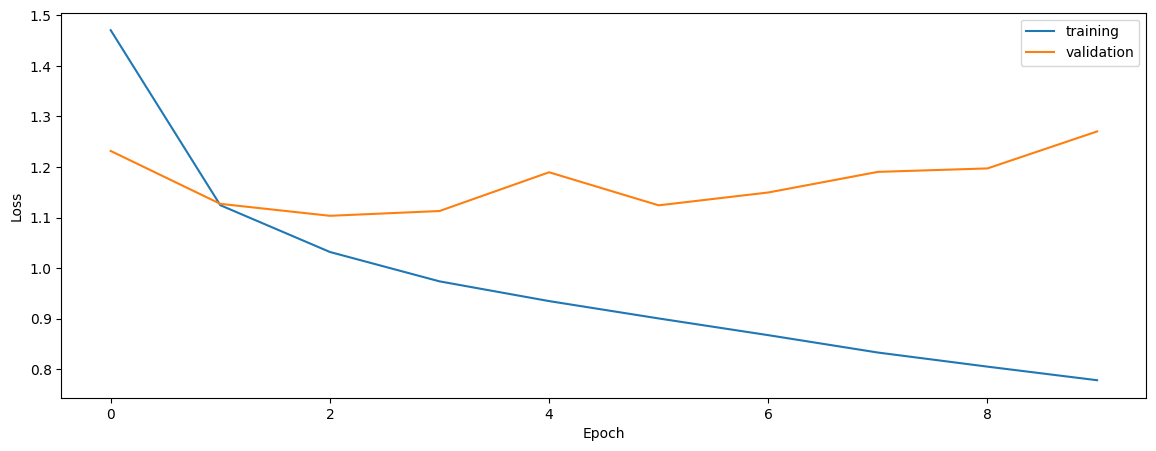

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6087328144951709
0.5586437795610353
0.5468482902245574


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5758539413473949
0.568863754229126
0.556829035339064


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5584272911246024
0.5518435526583826
0.5407649723200805


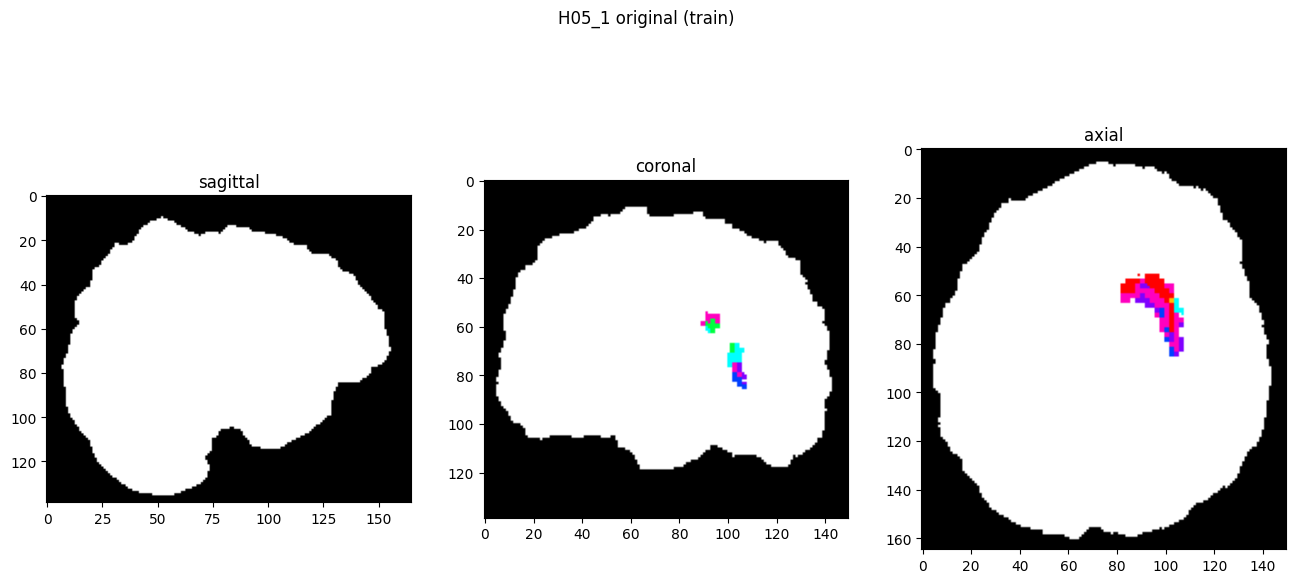

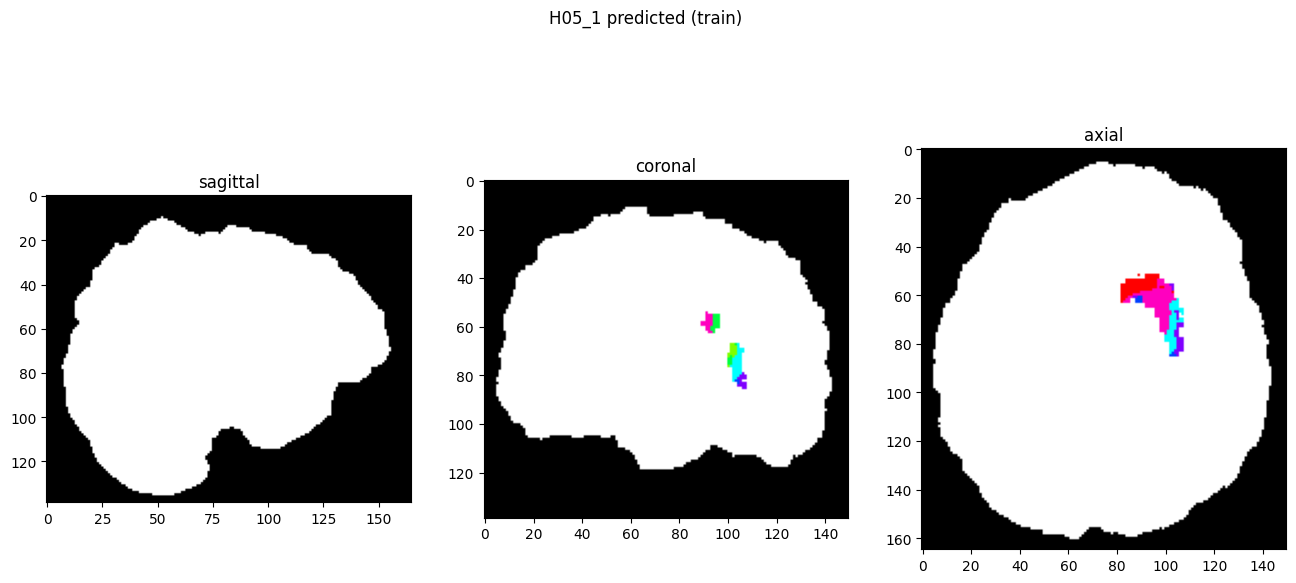

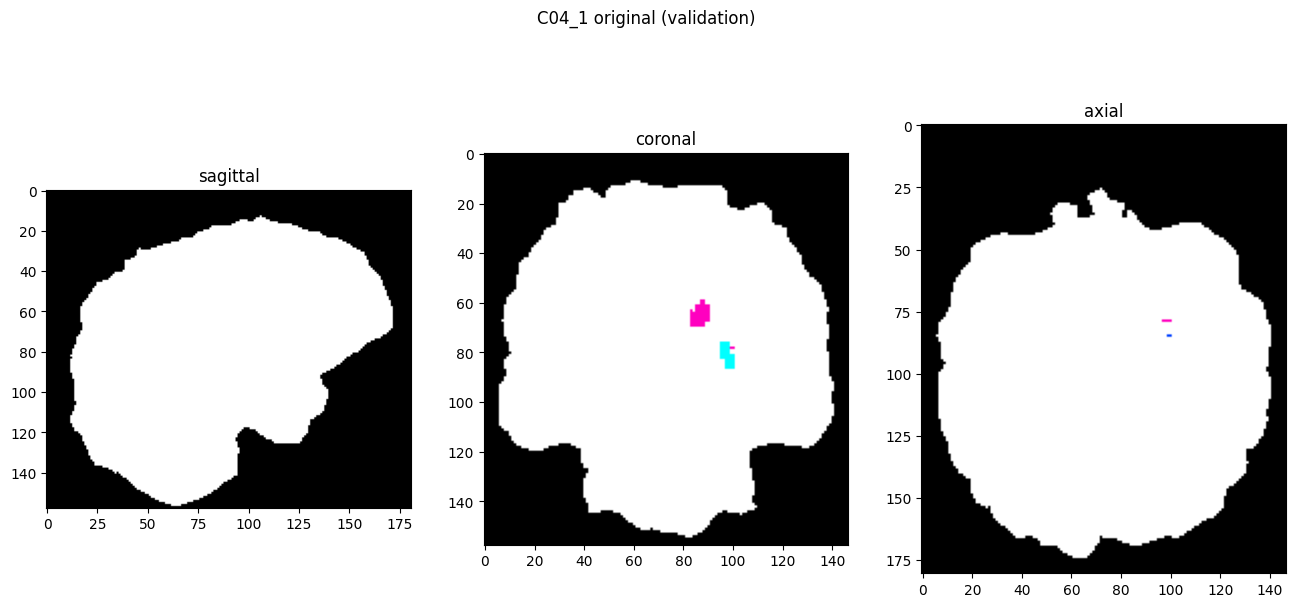

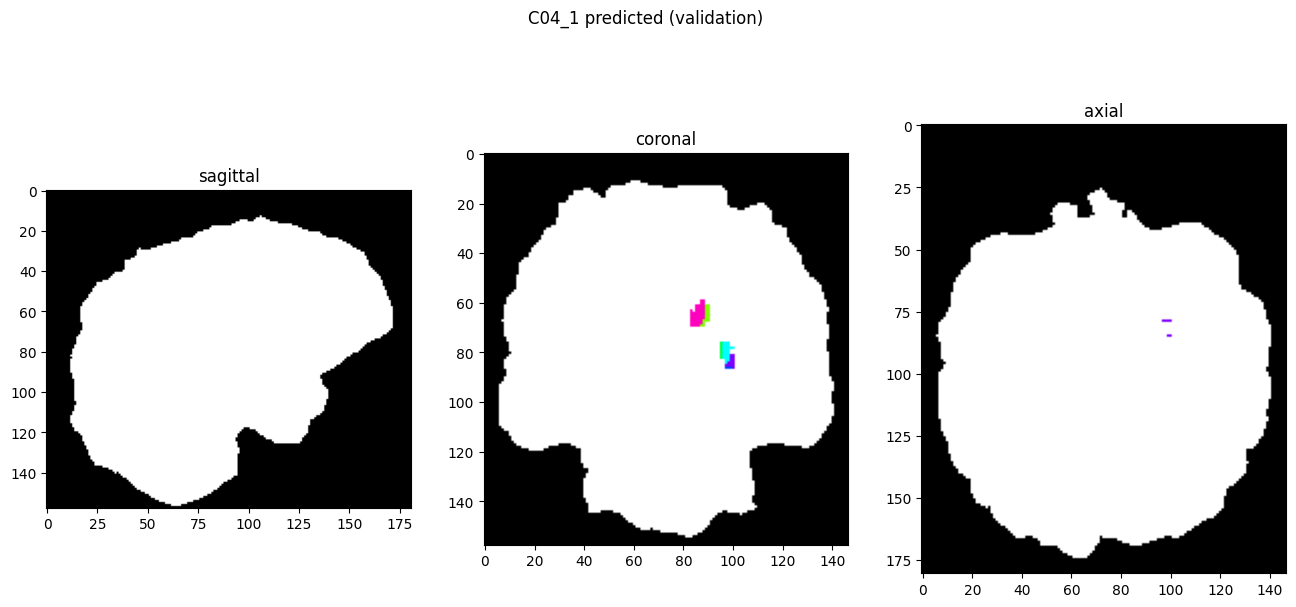

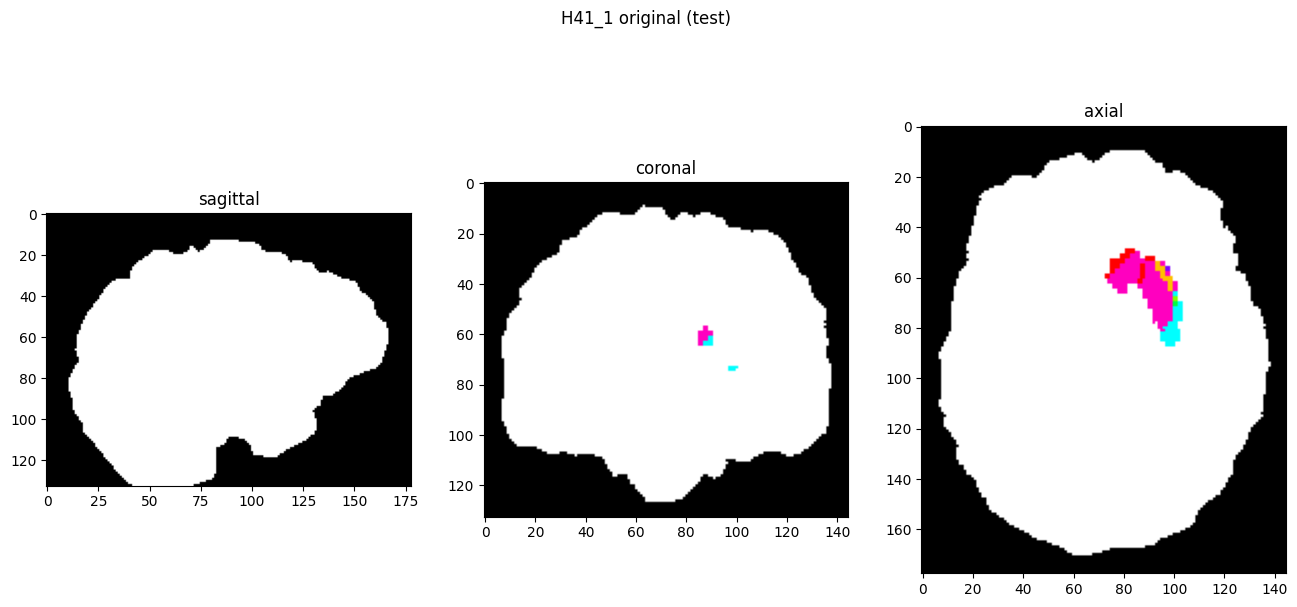

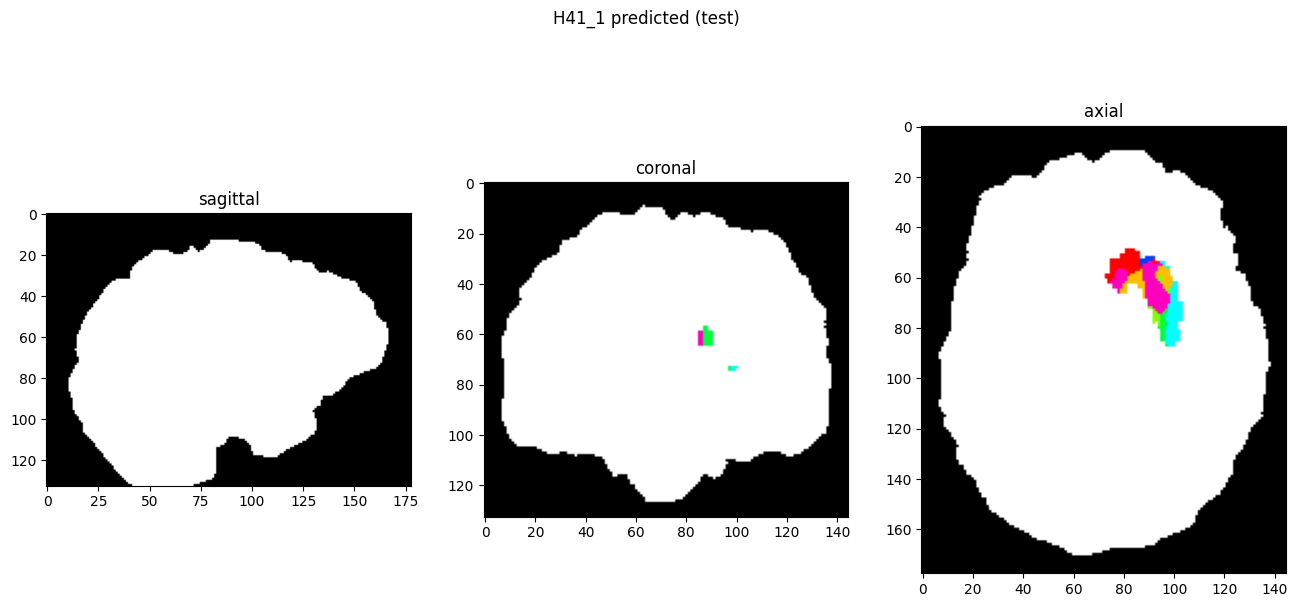

In [10]:
showResults(model, gen, threshold=0)